# **Exploratory Data Analyst : Case Mall Customers**
---
Analisis menggunakan datasheet Mall Customer untuk menemukan pola konsumen yang paling sering berbelanja berdasarkan jenis kelamin, pendapatan tahunan, skor pengeluaran, kategori usia dan lain-lain 

# **1. Load datasheet from postgresql**
---
pertama kita akan membuat koneksi database ke postgresql pada tabel customer_segmentation untuk datasheet yang akan kita gunakan dalam proses analisis 

### **Buat Koneksi PostgreSQL dengan menggunakan class oop**
--- 
Untuk bagian pertama ini kita akan membuat class oop untuk koneksi dengan database postgresql 

In [1]:
import pandas as pd  # library untuk pengolahan dataframe
import numpy as np   # library untuk komputasi numerik
import psycopg2      # library untuk koneksi dengan database postgresql 

# library untuk handling error 
import warnings

# buat variabel untuk handling error
warnings.filterwarnings('ignore')

# buat class untuk koneksi database 
class PostgresDB:
    def __init__(self):
        """
        Inisialisasi koneksi ke database PostgreSQL dengan konfigurasi yang sudah ditentukan.
        """
        self.host = 'localhost'
        self.dbname = 'DB_ML'
        self.user = 'postgres'
        self.password = 'admin'
        self.port = 5432
        self.conn = None
        self.cursor = None

    def connect(self):
        """
        Membuka koneksi ke database.
        """
        try:
            self.conn = psycopg2.connect(
                host=self.host,
                dbname=self.dbname,
                user=self.user,
                password=self.password,
                port=self.port
            )
            self.cursor = self.conn.cursor()
            print("Connection successful.")
        except Exception as e:
            print(f"Error connecting to database: {e}")

    def execute_query(self, query):
        """
        Menjalankan query SQL dan mengembalikan hasil sebagai DataFrame.
        :param query: Query SQL yang akan dijalankan
        :return: DataFrame dengan hasil query
        """
        try:
            if self.cursor is None:
                raise Exception("Database not connected. Call connect() first.")

            self.cursor.execute(query)
            columns = [desc[0] for desc in self.cursor.description]
            rows = self.cursor.fetchall()
            return pd.DataFrame(rows, columns=columns)
        except Exception as e:
            print(f"Error executing query: {e}")
            return None

    def close(self):
        """
        Menutup koneksi ke database.
        """
        if self.cursor:
            self.cursor.close()
        if self.conn:
            self.conn.close()
        print("Connection closed.")

In [2]:
# Contoh penggunaan
if __name__ == "__main__":
    # Membuat instance PostgresDB
    db = PostgresDB()

    # Membuka koneksi
    db.connect()

    # Menjalankan query
    query = "SELECT * FROM customer_segmentation;"

    # Menjalankan query dengan class PostgresDB
    df = db.execute_query(query)

    # Jika result sudah berupa DataFrame
    if df is not None:
        print(df.head())


print("""
Dari datasheet tersebut dapat diketahui bahwa kita bisa melakukan analisis 
untuk menemukan insight dengan memanfaatkan kolom annual income dan spending score 
terhadap gender dan kategori usia sehingga hasil akhirnya kita bisa membuat 
analisis customer segmentation dan meningkatkan penjualan.
""")

Connection successful.
   CustomerID  Gender  Age  Annual Income (k$)  Spending Score (1-100)  \
0           1    Male   19                  15                      39   
1           2    Male   21                  15                      81   
2           3  Female   20                  16                       6   
3           4  Female   23                  16                      77   
4           5  Female   31                  17                      40   

  kategori_usia  
0   Dewasa Muda  
1   Dewasa Muda  
2   Dewasa Muda  
3   Dewasa Muda  
4        Dewasa  

Dari datasheet tersebut dapat diketahui bahwa kita bisa melakukan analisis 
untuk menemukan insight dengan memanfaatkan kolom annual income dan spending score 
terhadap gender dan kategori usia sehingga hasil akhirnya kita bisa membuat 
analisis customer segmentation dan meningkatkan penjualan.



## **1.1 Melihat komposisi dari datasheet yang digunakan**
--- 
pertama kita akan melihat komposisi dari datasheet yang kita gunakan seperti jumlah baris dan kolom, dan tipe data serta mengecek apakah ada data yang nilai nya mengalami missing value dan lain-lain

In [3]:
print(f'Jumlah baris pada datasheet tersebut berjumlah : {df.shape[0]} baris') # mengecek jumlah baris pada datasheet
print(f'Jumlah kolom pada datasheet tersebut berjumlah : {df.shape[1]} kolom') # mengecek jumlah kolom pada datasheet 

print("""
ternyata jumlah komposisi pada datasheet kita berjumlah 200 baris data dan 6 kolom meskipun
jumlahnya sedikit kita akan memaksimalkan denganmenggunakan metode statistik yang sesuai agar 
memberikan haisl yang optimal 
""")

Jumlah baris pada datasheet tersebut berjumlah : 200 baris
Jumlah kolom pada datasheet tersebut berjumlah : 6 kolom

ternyata jumlah komposisi pada datasheet kita berjumlah 200 baris data dan 6 kolom meskipun
jumlahnya sedikit kita akan memaksimalkan denganmenggunakan metode statistik yang sesuai agar 
memberikan haisl yang optimal 



## **1.2 Mengecek apakah ada data yang bernilai missing value**
---
pada bagian ini kita akan melakukan pengecekan untuk mengetahui apakah ada data yang mengalami missing value pada datasheet yang kita gunakan dan menghapus atau mengganti nilai yang missing value tersebut sebelum dilanjutkan ke dalam proses berikut nya 

In [4]:
# mengecek apakah ada data yang mengalami missing value 
print(f'jumlah duplikasi : {df.duplicated().sum()} data')

print("""
ternyata tidak ada data yang mengalami misisng value sehingga kita bisa lanjutkan ke tahap berikutnya 
yaitu analisis outlier untuk mengetahui bahwa apakah ada fitur yang mengalami outliers yang mungkin 
bisa mempengarui kinerja dari model yang kita buat nanti
""")

jumlah duplikasi : 0 data

ternyata tidak ada data yang mengalami misisng value sehingga kita bisa lanjutkan ke tahap berikutnya 
yaitu analisis outlier untuk mengetahui bahwa apakah ada fitur yang mengalami outliers yang mungkin 
bisa mempengarui kinerja dari model yang kita buat nanti



# **2.Exploratory data analyst (EDA)**
---
Tahap selanjutnya kita akan masuk kedalam tahap analisis EDA untuk melakukan preprocessing pada data yang meliputi pembersihan pada data dan mencari insight yang mungkin bisa memberikan keuntungan kedepan nya 

## **2.1 Rename columns**
---
pada proses ini kita akan melakukan perubahan nama fitur pada kolom datasheet kita agar mudah untuk melakukan analisis kedepannya 

In [5]:
# rename kolom annual income dan spending skor 
df = df.rename(columns={'Annual Income (k$)':'Pendapatan_Tahunan', 'Spending Score (1-100)':'Skor_Pengeluaran'})
print(df.head())

print("""
dengan merubah nama kolom annual income (k$) dan spending score (1-100) kita bisa lebih mudah 
untuk melakukan analisis jika kita menggunakan 2 kolom tersebut nanti nya 
""")

   CustomerID  Gender  Age  Pendapatan_Tahunan  Skor_Pengeluaran kategori_usia
0           1    Male   19                  15                39   Dewasa Muda
1           2    Male   21                  15                81   Dewasa Muda
2           3  Female   20                  16                 6   Dewasa Muda
3           4  Female   23                  16                77   Dewasa Muda
4           5  Female   31                  17                40        Dewasa

dengan merubah nama kolom annual income (k$) dan spending score (1-100) kita bisa lebih mudah 
untuk melakukan analisis jika kita menggunakan 2 kolom tersebut nanti nya 



## **2.2 Analisis data outlier dan visualisasi boxplot**
---
selanjutnya kita akan melakukan visulisasi data dengan boxplot untuk melihat penyebaran dari dari fitur data yang kita miliki 

In [6]:
import matplotlib.pyplot as plt # library untuk visualisasi data 
import seaborn as sns           # library untuk visualisasi data 

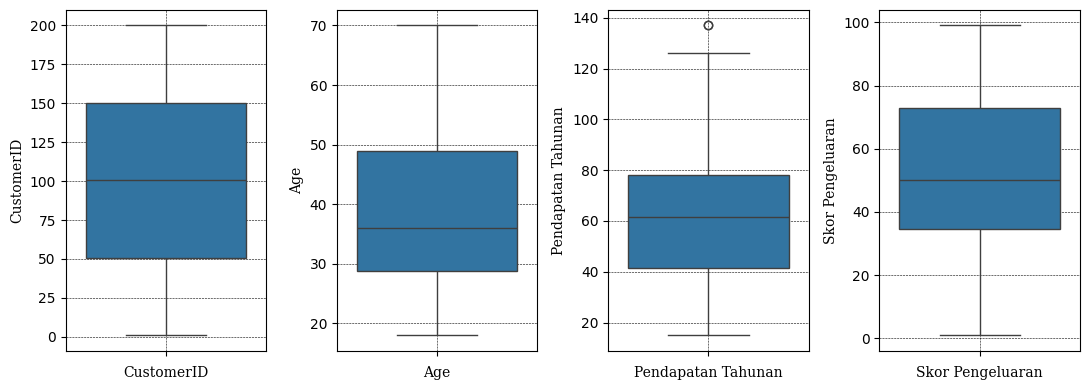


dari hasil analisis berikut ternyata ada satu kolom yang mengalami nilai outlier 
yaitu kolom pendapatan tahunan selanjutnya kita akan mencari tahu berapa jumlah 
data outlier dari kolom pendapatan tahunan sehingga kita bisa menggunakan metode 
statistik yang tepat apakah harus menghapus data atau merubah dengan metdoe tertentu



In [7]:
# Buat visualisasi data dengan boxplot
fig, axs = plt.subplots(1, 4, figsize=(11, 4))

# Fungsi untuk membuat boxplot
def create_boxplot(ax, y, label):
    sns.boxplot(y=y, data=df, ax=ax)
    ax.set_xlabel(label, fontsize=10, fontfamily='serif')
    ax.set_ylabel(label, fontsize=10, fontfamily='serif')
    ax.grid(color='black', linestyle='--', linewidth=0.4)

# Buat grafik visualisasi data
create_boxplot(axs[0], 'CustomerID', 'CustomerID')
create_boxplot(axs[1], 'Age', 'Age')
create_boxplot(axs[2], 'Pendapatan_Tahunan', 'Pendapatan Tahunan')
create_boxplot(axs[3], 'Skor_Pengeluaran', 'Skor Pengeluaran')

plt.tight_layout()
plt.show()

print("""
dari hasil analisis berikut ternyata ada satu kolom yang mengalami nilai outlier 
yaitu kolom pendapatan tahunan selanjutnya kita akan mencari tahu berapa jumlah 
data outlier dari kolom pendapatan tahunan sehingga kita bisa menggunakan metode 
statistik yang tepat apakah harus menghapus data atau merubah dengan metdoe tertentu
""")

### **2.2.1 Menghitung jumlah nilai outlier yang terdeteksi pada semua kolom**
---
pada tahap ini kita akan melakukan analisis untuk mengetahui jumlah outlier pada semua kolom fitur yang kita punya dan mencari solusi terbaik untuk menghilangkan outliers tersebut. Karena isi data kita hanya berjumlah 200, dengan data yang sedikit ini kita ingin memaksimalkan informasi yang bisa di dapat dari data tersebut

In [8]:
# buat fungsi untuk menghitung jumlah nilai outlier pada setiap kolom
def detect_outliers(data, x):
    Q1 = df[x].describe()['25%']
    Q3 = df[x].describe()['75%']
    IQR = Q3-Q1
    return df[(df[x] < Q1-1.5*IQR) | (df[x] > Q3+1.5*IQR)]

# print jumlah kolom yang terdeteksi sebagai outlier 
print(detect_outliers(df,'Pendapatan_Tahunan').count() + detect_outliers(df,'Skor_Pengeluaran').count())

print("""
sekarang kita mengetahui bahwa ternyata outliers ada di semua fitur kita dengan jumlah 12 data 
sehingga kita perlu menagani 12 data ini agar tidak mempengaruhi pada saat pembuatan model
""")

CustomerID            2
Gender                2
Age                   2
Pendapatan_Tahunan    2
Skor_Pengeluaran      2
kategori_usia         2
dtype: int64

sekarang kita mengetahui bahwa ternyata outliers ada di semua fitur kita dengan jumlah 12 data 
sehingga kita perlu menagani 12 data ini agar tidak mempengaruhi pada saat pembuatan model



### **2.2.2 Preprocessing dengan teknik winsorize**
---
Pada bagian ini kita akan melakukan analisis untuk menghilangkan nilai outlier menggunakan teknik winsorize dengan mebggunakan teknik ini kita tidak perlu menghapus nilai outlier sehingga meskipun datasheet yang kita punya sedikit dan ada nilai outlier kita perlu menghapus yang mengakibatkan data yang kita punya jadi sedikit

In [9]:
# import library yang dibutuhkan untuk preprocessing data dengan teknik winsorize
from scipy.stats.mstats import winsorize
import warnings

# buat variabel untuk menghilangkan error pada saat proses normalisasi data 
warnings.filterwarnings('ignore')

# gunakan kolom pendapatan tahunan dan skor pengeluaran sebagai fitur yang ingin di normalisasi 
df['Pendapatan_Tahunan'] = winsorize(df['Pendapatan_Tahunan'], limits=[0.05, 0.05])
df['Skor_Pengeluaran'] = winsorize(df['Skor_Pengeluaran'], limits=[0.05, 0.05])

# print jumlah kolom yang terdeteksi sebagai outlier 
print(detect_outliers(df,'Pendapatan_Tahunan').count() + detect_outliers(df,'Skor_Pengeluaran').count())

print("""
sekarang kita mengetahui bahwa tidak ada lagi outliers pada semua fitur yang kita punya 
dengan teknik winsorize ini kita dapat melakukann preprocesing pada data tanpa harus 
menghapus data untuk menghilangkan outliers melainkan merubah data tersbeut dengan nilai 
dari persentil tertentu, pada contoh ini kita menggunakan persentil ke 5 untuk normalisasi data
""")

CustomerID            0
Gender                0
Age                   0
Pendapatan_Tahunan    0
Skor_Pengeluaran      0
kategori_usia         0
dtype: int64

sekarang kita mengetahui bahwa tidak ada lagi outliers pada semua fitur yang kita punya 
dengan teknik winsorize ini kita dapat melakukann preprocesing pada data tanpa harus 
menghapus data untuk menghilangkan outliers melainkan merubah data tersbeut dengan nilai 
dari persentil tertentu, pada contoh ini kita menggunakan persentil ke 5 untuk normalisasi data



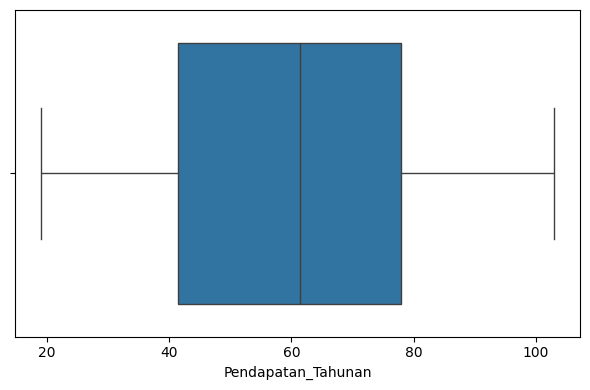


Dari visualisasi berikut dapat diketahui bahwa sekarang tidak ada lagi data yang mengalami outlier 
terutama pada fitur pendapatan tahunan sehingga kita bisa menggunakan data ini untuk analisis lebih lanjut



In [10]:
# mengecek kembali kolom fitur pendapatan setelah dilakukan normalisasi data dengan teknik winsorize
plt.figure(figsize=(6,4))
sns.boxplot(x = 'Pendapatan_Tahunan', data = df)
plt.tight_layout()
plt.show()

print("""
Dari visualisasi berikut dapat diketahui bahwa sekarang tidak ada lagi data yang mengalami outlier 
terutama pada fitur pendapatan tahunan sehingga kita bisa menggunakan data ini untuk analisis lebih lanjut
""")

## **2.3 Analisis distribusi data dan central tedency**
---
pada tahap ini melakukan analisis untuk mengetahui distribusi dan central tedency dari data yang kita punya untuk mendapatkan informasi yang mungkin berguna untuk kegiatan memahami pola customer dalam berbelanja berdasarkan usia, jenis kelamin, pendapatan dan skor pengeluaran

In [11]:
# import library untuk distribusi normal dengan scipy dan buat class oop untuk analisis kde 
from scipy.stats import norm

class DataVisualizer:
    def __init__(self, data):
        self.data = data

    def plot_kde_pdf_cdf(self, column_name, x_label="", y_labels=("", ""), title="", figsize=(8, 4)):
        # Calculate mean and standard deviation
        mean = self.data[column_name].mean()
        std = self.data[column_name].std()

        # Calculate PDF and CDF
        pdf = norm.pdf(self.data[column_name], loc=mean, scale=std)
        cdf = norm.cdf(self.data[column_name], loc=mean, scale=std)

        # Create subplots
        fig, axs = plt.subplots(1, 2, figsize=figsize)

        # Plot PDF
        sns.kdeplot(x=self.data[column_name], lw=2, ax=axs[0])
        sns.lineplot(x=self.data[column_name], y=pdf, lw=2, ax=axs[0])
        axs[0].legend(["KDE", f"{column_name}_PDF"], shadow=True, fontsize=9, loc="upper left")
        axs[0].set_ylabel(y_labels[0], fontsize=12)

        # Plot CDF
        sns.kdeplot(x=self.data[column_name], cumulative=True, lw=2, ax=axs[1])
        sns.lineplot(x=self.data[column_name], y=cdf, lw=2, ax=axs[1])
        axs[1].legend(["KDE Cumulative", f"{column_name}_CDF"], shadow=True, fontsize=9)
        axs[1].set_ylabel(y_labels[1], fontsize=12)

        # Set titles and labels
        for ax in axs:
            ax.set_xlabel(x_label, fontsize=12)
            ax.set_title(title, fontsize=10, loc="left")
            ax.grid(axis="y", color='darkgray', linestyle='--', linewidth=0.5)

        # Adjust layout and show plot
        plt.tight_layout()
        plt.show()

### **2.3.1 Analisis distribusi data dan visualisasi untuk kolom pendapatan tahunan** 
--- 
pada tahap ini kita akan melakukan pengujian distribusi data untuk fitur pendapatan tahunan 

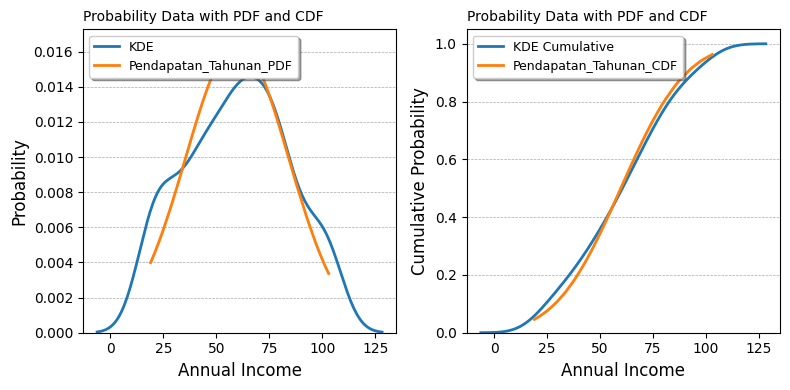


Dari hasil visualisasi tersebut dapat diketahui bahwa nilai probabilitas kde dan pdf tidak terlalu jauh
dan grafik nya cenderung berada di tengah sehingga dalam hal ini distribusi data nya sudah normal



In [12]:
# panggil class DataVisualizer
visualizer = DataVisualizer(df)
# panggil function plot_kde_pdf_cdf
visualizer.plot_kde_pdf_cdf(
    column_name='Pendapatan_Tahunan', 
    x_label="Annual Income", 
    y_labels=("Probability", "Cumulative Probability"), 
    title="Probability Data with PDF and CDF"
)

print("""
Dari hasil visualisasi tersebut dapat diketahui bahwa nilai probabilitas kde dan pdf tidak terlalu jauh
dan grafik nya cenderung berada di tengah sehingga dalam hal ini distribusi data nya sudah normal
""")

### 2.3.2 Analisis distribusi data dan visualisasi untuk kolom skor pengeluaran
---
pada tahap uni kita akan melakukan pengujian distribusi data dan analisis untuk skor pengeluaran 

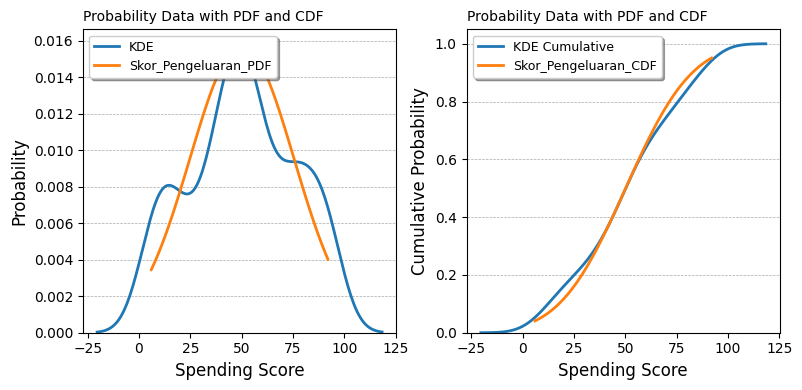


Dari hasil visualisasi tersebut dapat diketahui bahwa distribusi data PDF dan CDF dari kolom
spending score tepat berada di tengah sehingga dalam hal ini distribusi data nya sudah normal



In [13]:
# panggil class DataVisualizer
visualizer = DataVisualizer(df)
# panggil function plot_kde_pdf_cdf
visualizer.plot_kde_pdf_cdf(
    column_name='Skor_Pengeluaran', 
    x_label="Spending Score", 
    y_labels=("Probability", "Cumulative Probability"), 
    title="Probability Data with PDF and CDF"
)

print("""
Dari hasil visualisasi tersebut dapat diketahui bahwa distribusi data PDF dan CDF dari kolom
spending score tepat berada di tengah sehingga dalam hal ini distribusi data nya sudah normal
""")

### 2.3.3 Analisis distribusi data dan visualisasi untuk kolom data Age
--- 
Pada tahap ini kita akan melakukan analisis dan pengujian untuk data Age 

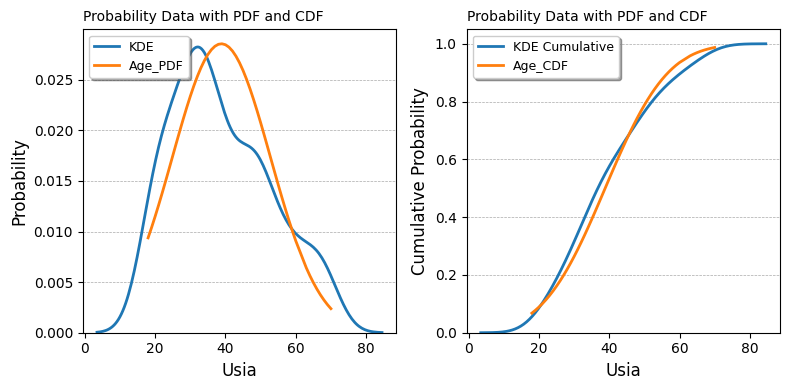


Dari hasil visualisasi tersebut dapat diketahui bahwa untuk PDF dan CDF dari kolom usia 
distribusi data nya cenderung skew ke kanan tapi ini masih normal dan bisa kita gunakan



In [14]:
# panggil class DataVisualizer
visualizer = DataVisualizer(df)
# panggil function plot_kde_pdf_cdf
visualizer.plot_kde_pdf_cdf(
    column_name='Age', 
    x_label="Usia", 
    y_labels=("Probability", "Cumulative Probability"), 
    title="Probability Data with PDF and CDF"
)

print("""
Dari hasil visualisasi tersebut dapat diketahui bahwa untuk PDF dan CDF dari kolom usia 
distribusi data nya cenderung skew ke kanan tapi ini masih normal dan bisa kita gunakan
""")

## **2.4 Analisis Statistik deskriptif dengan query SQL** 
---
pada tahap ini kita akan melakukan analisis yang sebenarnya menggunakan query SQL dan mengintegrasikan nya dengan python agar selain analisis dengan query kita juga bisa menggunakan python untuk membuat visualisasi data lebih lanjut

### **1 Analisis deskriptif untuk distribusi jenis kelamin**
---
pada bagian ini kita akan melakukan analisis untuk mengetahui jumlah jenis kelamin yang paling sering berbelanja

In [15]:
# Query SQL untuk analisis distribusi gender
query = """
SELECT "Gender", COUNT(*) AS jumlah_pelanggan
FROM customer_segmentation
GROUP BY "Gender";
"""
# Menjalankan query dengan class PostgresDB
gender_distribution_df = db.execute_query(query)

# Jika result sudah berupa DataFrame
if gender_distribution_df is not None:
    print(gender_distribution_df.head())

print("""
Dari hasil output berikut kita bisa ketahui bahwa jenis kelamin perempuan 
adalah yan paling sering berbelanja dari semua kategori usia sebanyak 112
dari pada jenis kelamin laki-laki dari berbagai kategori usia yang hanya berjumlah 88 
""")

   Gender  jumlah_pelanggan
0  Female               112
1    Male                88

Dari hasil output berikut kita bisa ketahui bahwa jenis kelamin perempuan 
adalah yan paling sering berbelanja dari semua kategori usia sebanyak 112
dari pada jenis kelamin laki-laki dari berbagai kategori usia yang hanya berjumlah 88 



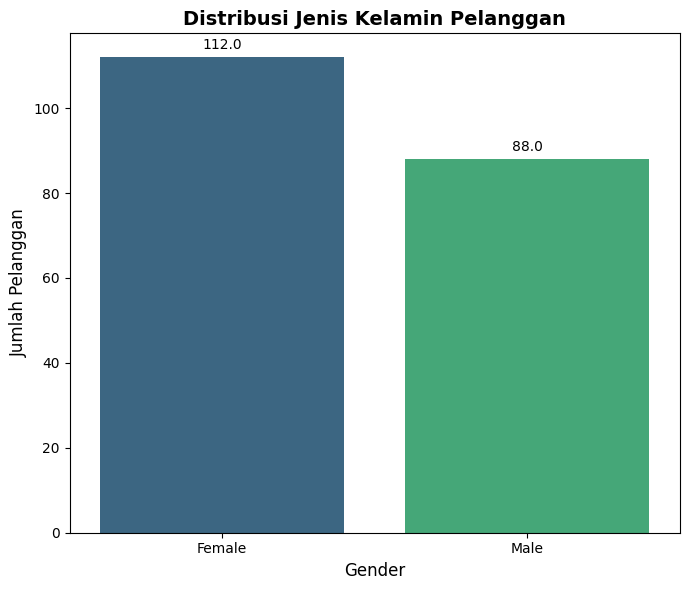

Penjelasan:
1) Dari Visualisasi diatas dapat diketahui bahwa distribusi pelanggan lebih banyak jatuh kepada perempuan
2) Dan distribusi pelanggan untuk laki-laki tidak sebanyak perempuan yang berjumlah 112


In [16]:
# Set ukuran figure
plt.figure(figsize=(7,6))

# Buat visualisasi barplot untuk distribusi jenis kelamin
barplot = sns.barplot(x='Gender', y='jumlah_pelanggan', data=gender_distribution_df, palette='viridis')

# Tambahkan judul dan label sumbu
plt.title('Distribusi Jenis Kelamin Pelanggan', fontsize=14, fontweight='bold')
plt.xlabel('Gender', fontsize=12)
plt.ylabel('Jumlah Pelanggan', fontsize=12)

# Tambahkan label pada setiap batang
for p in barplot.patches:
    barplot.annotate(format(p.get_height(), '.1f'),
                    (p.get_x() + p.get_width() / 2., p.get_height()), 
                    ha = 'center', va = 'center', 
                    xytext = (0, 9), 
                    textcoords = 'offset points')

# Atur tata letak agar lebih rapi
plt.tight_layout()

# Tampilkan plot
plt.show()

print("Penjelasan:\n"
        "1) Dari Visualisasi diatas dapat diketahui bahwa distribusi pelanggan lebih banyak jatuh kepada perempuan\n"
        "2) Dan distribusi pelanggan untuk laki-laki tidak sebanyak perempuan yang berjumlah 112")

### **2. Analisis deskriptif untuk pengeluaran terbanyak berdasarkan jenis kelamin**
--- 
dari analisis diatas kita mengetahui bahwa perempuan merupakan customer terbanyak dari pada laki-laki, kita akan mencoba mencari insight lebih lanjut apakah dengan banyak nya customer perempuan yang melakukan transaksi sejalan dengan pengeluaran terbanyak atau jangan-jangan laki-laki lah yang paling banyak dal hal pengelaran 

In [17]:
query = """
SELECT "Gender", ROUND(AVG("Annual Income (k$)")) AS rata_rata_penghasilan
FROM customer_segmentation
GROUP BY "Gender";
"""

# Menjalankan query dengan class PostgresDB
annual_income_avg_df = db.execute_query(query)

# Jika result sudah berupa DataFrame
if annual_income_avg_df is not None:
    print(annual_income_avg_df.head())

print("""
Dari hasil output berikut dapat diketahui bahwa ternyata meskipun perempuan dari berbagai usia adalah customer terbanyak 
tapi kenyataan nya laki-laki lah yang paling banyak penghasilan meskipun laki-laki bukan pembeli terbanyak
kita akan mencoba untuk mencari tahu bagaimana ini bisa terjadi dan menentukan strategi pasar untuk kedepan nya
"""
)

   Gender rata_rata_penghasilan
0  Female                    59
1    Male                    62

Dari hasil output berikut dapat diketahui bahwa ternyata meskipun perempuan dari berbagai usia adalah customer terbanyak 
tapi kenyataan nya laki-laki lah yang paling banyak penghasilan meskipun laki-laki bukan pembeli terbanyak
kita akan mencoba untuk mencari tahu bagaimana ini bisa terjadi dan menentukan strategi pasar untuk kedepan nya



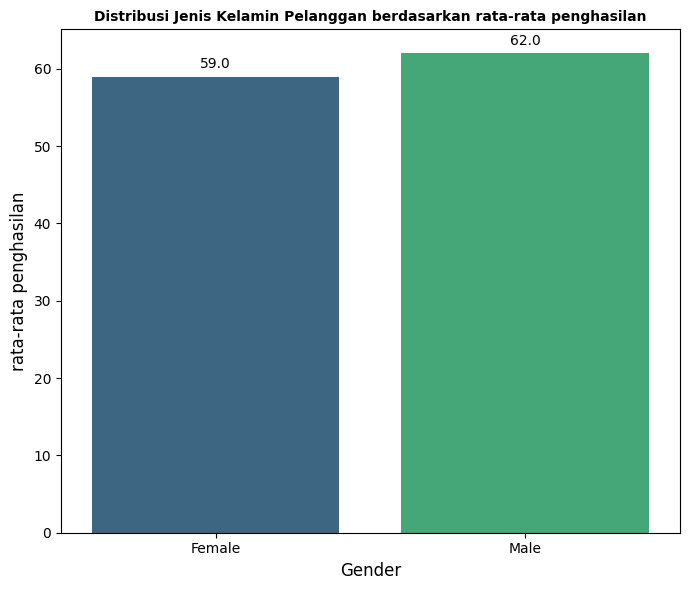

Penjelasan:
1) Dari Visualisasi diatas dapat diketahui bahwa rata-rata penghasilan laki-laki jauh lebih banyak dari pada perempuan
2) ini mengindikasikan bahwa meskipun laki-laki memiliki pendapatan besar tapi sedikit pengeluaran


In [18]:
# set ukuran figure 
plt.figure(figsize=(7,6))

# buat visualisasi barplot untuk distribusi jenis kelamin 
barplot = sns.barplot(x = "Gender", y = "rata_rata_penghasilan", data=annual_income_avg_df, palette="viridis")

# tambahkan judul dan label sumbu 
plt.title('Distribusi Jenis Kelamin Pelanggan berdasarkan rata-rata penghasilan', fontsize=10, fontweight='bold')
plt.xlabel('Gender', fontsize=12)
plt.ylabel('rata-rata penghasilan', fontsize=12)

# Tambahkan label pada setiap batang
for p in barplot.patches:
    barplot.annotate(format(p.get_height(), '.1f'),
                    (p.get_x() + p.get_width() / 2., p.get_height()), 
                    ha = 'center', va = 'center', 
                    xytext = (0, 9), 
                    textcoords = 'offset points')

plt.tight_layout()
plt.show()

print("Penjelasan:\n"
        "1) Dari Visualisasi diatas dapat diketahui bahwa rata-rata penghasilan laki-laki jauh lebih banyak dari pada perempuan\n"
        "2) ini mengindikasikan bahwa meskipun laki-laki memiliki pendapatan besar tapi sedikit pengeluaran")

### **3. Analisis untuk pengeluaran terbanyaj berdasarkan jenis kelamin**
---
setelah melakukan analsis untuk pendapatan terbanyak selanjutnya kita akan mencoba untuk mencari pengeluaran terbanyak berdasarkan jenis kelamin jika sebelumnya diketahui bahwa perempuan adalah konsumen kita yang paling aktif berbelanja dan laki-laki adalah konsumen dengan penghasilan terbanyak

In [19]:
# query untuk analisis pengeluaran terbanyak berdasarkan jenis kelamin 
query = """
SELECT "Gender", ROUND(AVG("Spending Score (1-100)")) AS rata_rata_pengeluaran
FROM customer_segmentation
GROUP BY "Gender";
"""
# Menjalankan query dengan class PostgresDB
spending_score_average_df = db.execute_query(query)

# Jika result sudah berupa DataFrame
if spending_score_average_df is not None:
    print(spending_score_average_df.head())


print("""
Dari hasil output berikut dapat diketahui bahwa ternyata perempuan dari berbagai usia memiliki skor pengeluaran yang lebih banyak
dibandingkan laki-laki kita akan mencoba untuk mencari tahu bagaimana ini bisa terjadi dan menentukan strategi pasar untuk kedepan nya
"""
)

   Gender rata_rata_pengeluaran
0  Female                    52
1    Male                    49

Dari hasil output berikut dapat diketahui bahwa ternyata perempuan dari berbagai usia memiliki skor pengeluaran yang lebih banyak
dibandingkan laki-laki kita akan mencoba untuk mencari tahu bagaimana ini bisa terjadi dan menentukan strategi pasar untuk kedepan nya



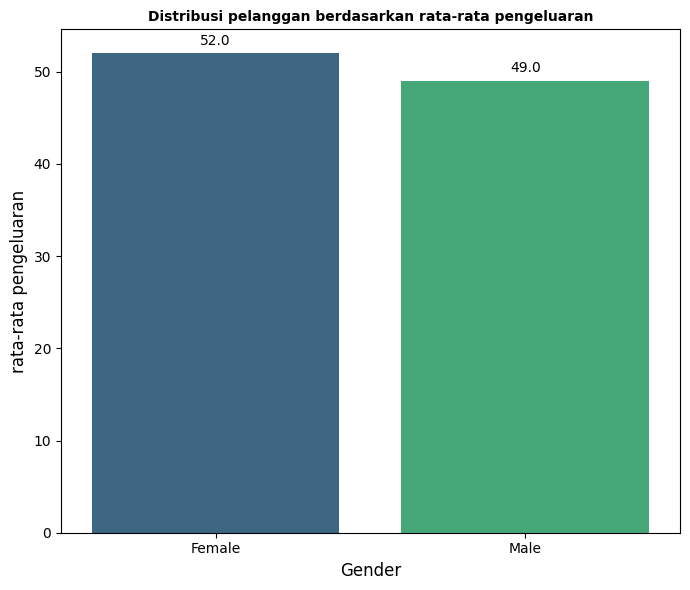

Penjelasan:
1) Dari Visualisasi diatas dapat diketahui bahwa rata-rata pengeluaran perempuan jauh lebih banyak dari pada laki-laki
2) ini mengindikasikan bahwa meskipun laki-laki memiliki pendapatan besar tapi sedikit pengeluaran


In [20]:
# set ukuran figure 
plt.figure(figsize=(7,6))

# buat visualisasi barplot untuk distribusi jenis kelamin 
barplot = sns.barplot(x = "Gender", y= "rata_rata_pengeluaran", data=spending_score_average_df, palette="viridis")

# tambahkan judul dan label sumbu 
plt.title('Distribusi pelanggan berdasarkan rata-rata pengeluaran', fontsize=10, fontweight='bold')
plt.xlabel('Gender', fontsize=12)
plt.ylabel('rata-rata pengeluaran', fontsize=12)

# Tambahkan label pada setiap batang
for p in barplot.patches:
    barplot.annotate(format(p.get_height(), '.1f'),
                    (p.get_x() + p.get_width() / 2., p.get_height()), 
                    ha = 'center', va = 'center', 
                    xytext = (0, 9), 
                    textcoords = 'offset points')

plt.tight_layout()
plt.show()

print("Penjelasan:\n"
        "1) Dari Visualisasi diatas dapat diketahui bahwa rata-rata pengeluaran perempuan jauh lebih banyak dari pada laki-laki\n"
        "2) ini mengindikasikan bahwa meskipun laki-laki memiliki pendapatan besar tapi sedikit pengeluaran")

### **4. Analisis pendapatan dan pengeluaran berdasarkan jenis kelamin**
---
selanjutnya kita akan mencoba untuk analisis annual income (k$) & spending score(1-100) untuk mencari tau berapa total pendapatan dan pengeluaran berdasarkan jenis kelamin

In [21]:
# qurty untuk analisis pendapatan dan pengeluaran berdasarkan jenis kelamin
query = """
SELECT 
    "Gender", 
    ROUND(AVG("Annual Income (k$)")) AS rata_rata_pendapatan, 
    ROUND(AVG("Spending Score (1-100)")) AS rata_rata_pengeluaran
FROM customer_segmentation 
GROUP BY "Gender";
"""
avg_annual_spending_df = db.execute_query(query)

# Jika result sudah berupa DataFrame
if avg_annual_spending_df is not None:
    print(avg_annual_spending_df.head())

   Gender rata_rata_pendapatan rata_rata_pengeluaran
0  Female                   59                    52
1    Male                   62                    49


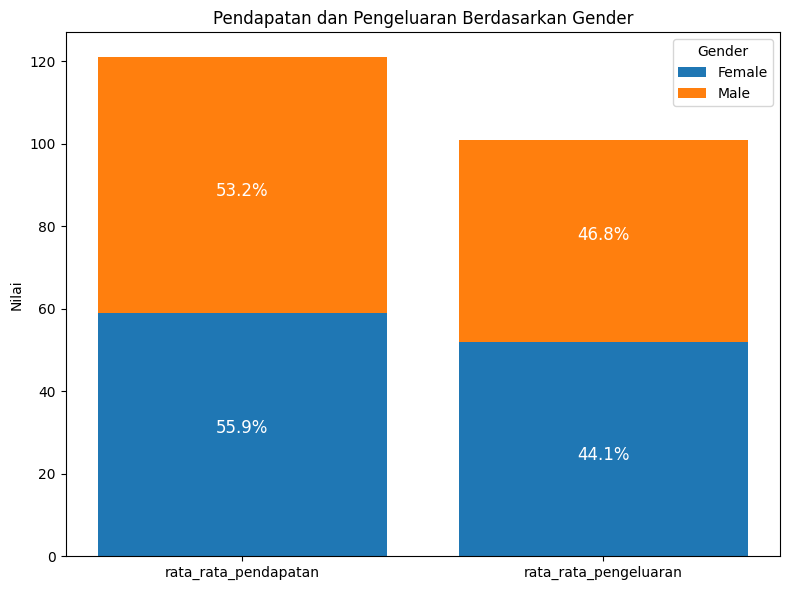

Proporsi Pendapatan dan Pengeluaran Berdasarkan Gender:
Female - Pendapatan: 53.2%, Pengeluaran: 46.8%
Male - Pendapatan: 55.9%, Pengeluaran: 44.1%


In [22]:
# Menyiapkan data untuk stacked bar chart
categories = ["rata_rata_pendapatan", "rata_rata_pengeluaran"]
labels = avg_annual_spending_df["Gender"].tolist()
data_values = avg_annual_spending_df[categories].values

# Menghitung total untuk setiap gender
total_values = data_values.sum(axis=1)

# Menghitung proporsi pendapatan dan pengeluaran terhadap total
proporsi_pendapatan = data_values[:, 0] / total_values * 100  # Kolom pendapatan / total
proporsi_pengeluaran = data_values[:, 1] / total_values * 100  # Kolom pengeluaran / total

# Plot stacked bar
fig, ax = plt.subplots(figsize=(8, 6))
for idx, label in enumerate(labels):
    bottom_value = data_values[:idx].sum(axis=0) if idx > 0 else None
    ax.bar(categories, data_values[idx], label=label, bottom=bottom_value)

    # Menambahkan label proporsi pendapatan pada setiap segmen batang pendapatan
    if label == "Male":
        ax.text(0, data_values[idx, 0] / 2, f'{proporsi_pendapatan[idx]:.1f}%', 
                ha='center', va='center', color='white', fontsize=12)
    if label == "Female":
        ax.text(0, data_values[idx, 0] / 2 + data_values[0, 0], 
                f'{proporsi_pendapatan[idx]:.1f}%', ha='center', va='center', color='white', fontsize=12)
    
    # Menambahkan label proporsi pengeluaran pada setiap segmen batang pengeluaran
    if label == "Male":
        ax.text(1, data_values[idx, 1] / 2, f'{proporsi_pengeluaran[idx]:.1f}%', 
                ha='center', va='center', color='white', fontsize=12)
    if label == "Female":
        ax.text(1, data_values[idx, 1] / 2 + data_values[0, 1], 
                f'{proporsi_pengeluaran[idx]:.1f}%', ha='center', va='center', color='white', fontsize=12)

# Menyesuaikan tampilan
ax.set_ylabel("Nilai")
ax.set_title("Pendapatan dan Pengeluaran Berdasarkan Gender")
ax.legend(title="Gender")

plt.tight_layout()
plt.show()

# Menampilkan hasil proporsi pendapatan dan pengeluaran
print("Proporsi Pendapatan dan Pengeluaran Berdasarkan Gender:")
for idx, label in enumerate(labels):
    print(f"{label} - Pendapatan: {proporsi_pendapatan[idx]:.1f}%, Pengeluaran: {proporsi_pengeluaran[idx]:.1f}%")


### **5. Analisis Distribusi Usia**
---
pada bagian ini kita akan membuat analisis untuk distribusi usia dan membuat visualisasi data nya 

In [23]:
# query untuk analisis distribusi usia 
query = """
SELECT "Age", COUNT(*) AS Jumlah
FROM customer_segmentation
GROUP BY "Age"
ORDER BY "Age";
"""

age_avg_df = db.execute_query(query)

# Jika result sudah berupa DataFrame
if age_avg_df is not None:
    print(age_avg_df.head())

   Age  jumlah
0   18       4
1   19       8
2   20       5
3   21       5
4   22       3


### **6. Analisis Rata-Rata Pengeluaran dan Pendapatan berdasarkan kelompok usia**
---
pada tahap ini kita akan mencoba untuk melakukan analisis rata-rata pendapatan serta pengeluaran berdasarkan kelompok usia 

In [24]:
# buat query untuk analisis rata-rata pengeluaran dan pendapatan berdasarkan kelompok usia
query = """
SELECT 
	CASE
        WHEN "Age" BETWEEN 18 AND 25 THEN '18-25'
        WHEN "Age" BETWEEN 26 AND 35 THEN '26-35'
        WHEN "Age" BETWEEN 36 AND 45 THEN '36-45'
        WHEN "Age" BETWEEN 46 AND 55 THEN '46-55'
        ELSE '56+'
    END AS age_group,
    ROUND(AVG("Annual Income (k$)")) AS avg_income, 
	ROUND(AVG("Spending Score (1-100)")) AS avg_score
FROM customer_segmentation
GROUP BY age_group;
"""
income_score_age_avg_df = db.execute_query(query)

# Jika result sudah berupa DataFrame
if income_score_age_avg_df is not None:
    print(income_score_age_avg_df.head())

  age_group avg_income avg_score
0     36-45         72        45
1     46-55         58        37
2     26-35         68        64
3     18-25         46        55
4       56+         54        38


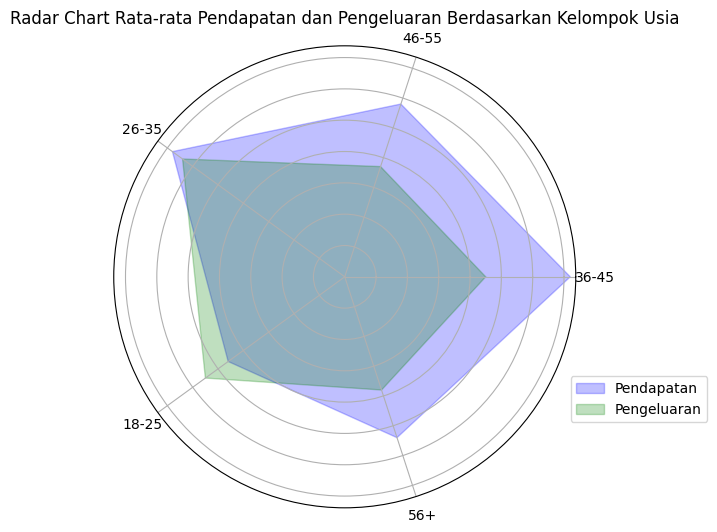

In [25]:
# Menyusun data untuk radar chart
labels = income_score_age_avg_df["age_group"].values
income_values = income_score_age_avg_df["avg_income"].values
score_values = income_score_age_avg_df["avg_score"].values

# Menyiapkan angka untuk chart
angles = np.linspace(0, 2 * np.pi, len(labels), endpoint=False).tolist()

# Memplot data pada radar chart
fig, ax = plt.subplots(figsize=(6, 6), subplot_kw=dict(polar=True))
ax.fill(angles, income_values, color='blue', alpha=0.25, label='Pendapatan')
ax.fill(angles, score_values, color='green', alpha=0.25, label='Pengeluaran')

# Menambahkan label untuk setiap sumbu
ax.set_yticklabels([])  # Menghilangkan label pada sumbu radial
ax.set_xticks(angles)
ax.set_xticklabels(labels)

# Menambahkan judul
ax.set_title("Radar Chart Rata-rata Pendapatan dan Pengeluaran Berdasarkan Kelompok Usia", loc='center')

# Menampilkan legend
ax.legend(loc='upper right', bbox_to_anchor=(1.3, 0.3))

# Menampilkan chart
plt.show()

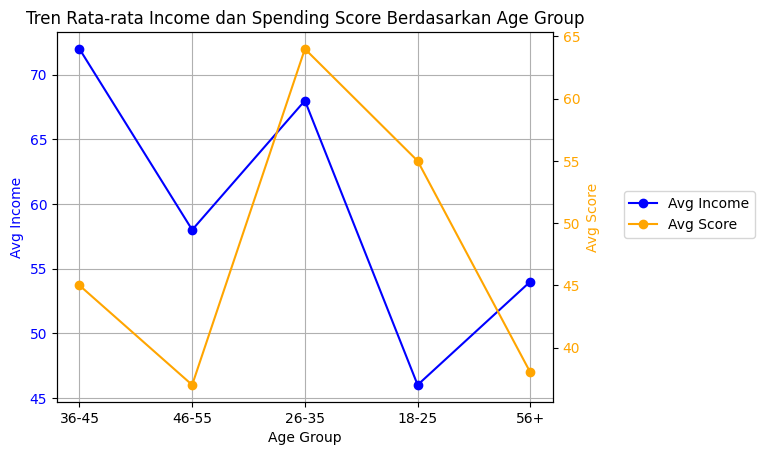

Penjelasan:
1) Rentang umur 36-45 tahun memiliki penghasilan tertinggi tapi memiliki skor pengeluaran yang rendah 
2) Rentang umur 46-55 tahun memiliki penghasilan tinggi tapi memiliki pengeluaran yang rendah 
3) Rentang umur 26-35 tahun memiliki penghasilan dan pengeluaran tinggi jika dibanding dengan umur 35 - 46 
4) Rentang umur 18-25 tahun memiliki penghasilan rendah tapi memiliki skor pengeluaran yang tinggi 
5) Rentang umur 56+ tahun memiliki rata-rata income dan score antara 35 untuk score dan penghasilan sebesar 45


In [26]:
fig, ax1 = plt.subplots()

# Plot avg_income
ax1.plot(income_score_age_avg_df['age_group'], income_score_age_avg_df['avg_income'], marker='o', color='blue', label='Avg Income')
ax1.set_xlabel('Age Group')
ax1.set_ylabel('Avg Income', color='blue')
ax1.tick_params(axis='y', labelcolor='blue')

# Create a second y-axis for avg_score
ax2 = ax1.twinx()
ax2.plot(income_score_age_avg_df['age_group'], income_score_age_avg_df['avg_score'], marker='o', color='orange', label='Avg Score')
ax2.set_ylabel('Avg Score', color='orange')
ax2.tick_params(axis='y', labelcolor='orange')

# Add title and grid
plt.title('Tren Rata-rata Income dan Spending Score Berdasarkan Age Group')
ax1.grid(True)

# Add legends
fig.legend(loc='center left', bbox_to_anchor=(1, 0.5))

plt.show()

print("Penjelasan:\n"
        "1) Rentang umur 36-45 tahun memiliki penghasilan tertinggi tapi memiliki skor pengeluaran yang rendah \n"
        "2) Rentang umur 46-55 tahun memiliki penghasilan tinggi tapi memiliki pengeluaran yang rendah \n"
        "3) Rentang umur 26-35 tahun memiliki penghasilan dan pengeluaran tinggi jika dibanding dengan umur 35 - 46 \n"
        "4) Rentang umur 18-25 tahun memiliki penghasilan rendah tapi memiliki skor pengeluaran yang tinggi \n" 
        "5) Rentang umur 56+ tahun memiliki rata-rata income dan score antara 35 untuk score dan penghasilan sebesar 45" )

### **7. Analisis korelasi pendapatan dan skor pengeluaran**
---
pada tahap imi kita akan membuat sebuah analisis untuk mengetahui apakah ada korelasi antara pendapatan dengan skor pengeluaran

In [27]:
query = """
SELECT 
    CASE 
        WHEN "Annual Income (k$)" BETWEEN 0 AND 3000 THEN 'Low Income'
        WHEN "Annual Income (k$)" BETWEEN 3001 AND 6000 THEN 'High Income'
        ELSE 'High Income'
    END AS income_group, 
        ROUND(AVG("Spending Score (1-100)")) AS avg_score
FROM customer_segmentation 
GROUP BY income_group;
"""

corr_annual_spending_df = db.execute_query(query)

# Jika result sudah berupa DataFrame
if corr_annual_spending_df is not None:
    print(corr_annual_spending_df.head())

  income_group avg_score
0   Low Income        50


### **8. Analisis distribusi penghasilan** 
---
pada bagian ini kita akan membuat analisis untuk distribusi penghasilan 

In [28]:
query = """
SELECT 
	CASE 
		WHEN "Annual Income (k$)" < 20000 THEN 'Low Income (< 20k)'
		WHEN "Annual Income (k$)" BETWEEN 20000 AND 50000 THEN 'Middle Income (20k-50k)'
		ELSE 'High Income (>50k)'
	END AS income_group,
	COUNT(*) AS jumlah_pelanggan
FROM customer_segmentation
GROUP BY income_group 
ORDER BY income_group;
"""

income_distribution_df = db.execute_query(query)

# Jika result sudah berupa DataFrame
if income_distribution_df is not None:
    print(income_distribution_df.head())

         income_group  jumlah_pelanggan
0  Low Income (< 20k)               200


### **10. Analisis rata-rata spending score**
---
pada bagian ini kita akan mencoba untuk melakukan analisis rata-rata spending score 

In [29]:
query = """
SELECT 
    CASE
        WHEN "Age" < 20 THEN 'Below 20'
        WHEN "Age" BETWEEN 20 AND 30 THEN '20 - 30'
        WHEN "Age" BETWEEN 31 AND 40 THEN '31 - 40'
        WHEN "Age" BETWEEN 41 AND 50 THEN '41 - 50'
        ELSE 'Above 50'
    END AS age_group,
    ROUND(AVG("Spending Score (1-100)")) AS rata_rata_spending_score
FROM customer_segmentation 
GROUP BY age_group
ORDER BY age_group;
"""

distribution_df = db.execute_query(query)

# Jika result sudah berupa DataFrame
if distribution_df is not None:
    print(distribution_df.head())

  age_group rata_rata_spending_score
0   20 - 30                       65
1   31 - 40                       58
2   41 - 50                       34
3  Above 50                       37
4  Below 20                       47


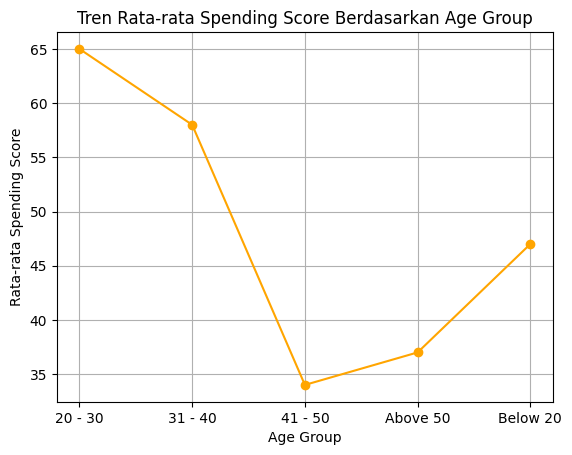

Penjelasan:
1) Rentang umur 20-30 tahun memiliki skor pengeluaran yang tinggi 
2) Rentang umur 31-40 tahun memiliki skor pengeluaran tinggi
3) Rentang umur 41-50 tahun memiliki skor pengeluaran yang paling rendah 
4) Rentang umur 18-25 tahun memiliki penghasilan rendah tapi memiliki skor pengeluaran yang tinggi 



In [30]:
plt.plot(distribution_df['age_group'], distribution_df['rata_rata_spending_score'], marker='o', color='orange')
plt.xlabel('Age Group')
plt.ylabel('Rata-rata Spending Score')
plt.title('Tren Rata-rata Spending Score Berdasarkan Age Group')
plt.grid(True)
plt.show()

print("Penjelasan:\n"
        "1) Rentang umur 20-30 tahun memiliki skor pengeluaran yang tinggi \n"
        "2) Rentang umur 31-40 tahun memiliki skor pengeluaran tinggi\n"
        "3) Rentang umur 41-50 tahun memiliki skor pengeluaran yang paling rendah \n"
        "4) Rentang umur 18-25 tahun memiliki penghasilan rendah tapi memiliki skor pengeluaran yang tinggi \n")

### **11. Analisis pelanggan dengan spending score tertinggi** 
---
pada bagian ini kita akan melakukan analisis untuk mengetahui pelanggan dari berbagai kategoru usia yang memiliki spending score tertinggi

In [31]:
query = """
SELECT 
    "Gender", 
    "Age",
    "Annual Income (k$)",
    "Spending Score (1-100)"
FROM customer_segmentation 
ORDER BY "Spending Score (1-100)" DESC
LIMIT 10
"""

coustumer_high_spending_df = db.execute_query(query)

# Jika result sudah berupa DataFrame
if coustumer_high_spending_df is not None:
    print(coustumer_high_spending_df.head())

   Gender  Age  Annual Income (k$)  Spending Score (1-100)
0  Female   35                  19                      99
1  Female   35                  23                      98
2    Male   30                  99                      97
3    Male   28                  77                      97
4  Female   33                  86                      95


### **12. Analisis kelompok belanja berdasarkan kategori usia**
---
pada bagian ini kita melakukan analisis untuk menentukan kelompok belanja terbanyak berdasarkan gender dan juga usia

In [32]:
query = """
SELECT
    "Gender", 
    "kategori_usia",
    COUNT("CustomerID") AS jumlah_pelanggan
FROM (
    SELECT 
        "CustomerID",
        "Gender",
        CASE
            WHEN "Age" <= 18 THEN 'Remaja'
            WHEN "Age" BETWEEN 19 AND 20 THEN 'Dewasa Muda'
            WHEN "Age" BETWEEN 31 AND 60 THEN 'Dewasa'
            ELSE 'Pensiun'
        END AS "kategori_usia"
    FROM customer_segmentation
) AS categorized_data
GROUP BY "Gender", "kategori_usia"
ORDER BY "Gender", "kategori_usia" ASC;
"""

customer_group_df = db.execute_query(query)

# Jika result sudah berupa DataFrame
if customer_group_df is not None:
    print(customer_group_df.head())

   Gender kategori_usia  jumlah_pelanggan
0  Female        Dewasa                72
1  Female   Dewasa Muda                 4
2  Female       Pensiun                35
3  Female        Remaja                 1
4    Male        Dewasa                49


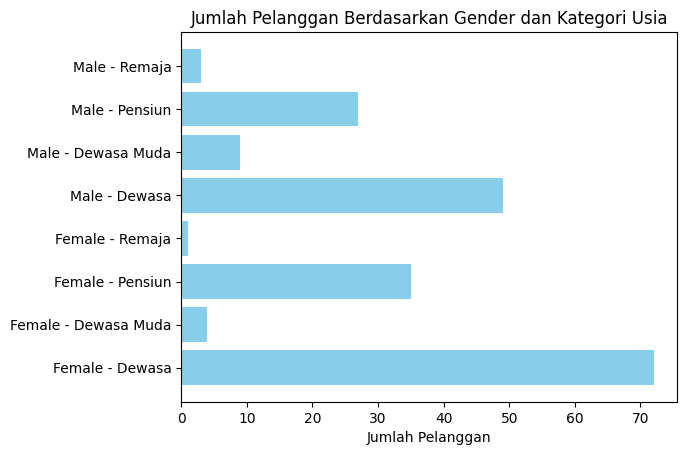

Penjelasan:
1) Rentang umur 20-30 tahun memiliki skor pengeluaran yang tinggi 
2) Rentang umur 31-40 tahun memiliki skor pengeluaran tinggi
3) Rentang umur 41-50 tahun memiliki skor pengeluaran yang paling rendah 
4) Rentang umur 18-25 tahun memiliki penghasilan rendah tapi memiliki skor pengeluaran yang tinggi 



In [33]:
# Data untuk grouped bar chart
categories = customer_group_df["kategori_usia"].unique()
male_counts = customer_group_df[customer_group_df["Gender"] == "Male"].set_index("kategori_usia")["jumlah_pelanggan"]
female_counts = customer_group_df[customer_group_df["Gender"] == "Female"].set_index("kategori_usia")["jumlah_pelanggan"]

male_counts = male_counts.reindex(categories, fill_value=0)
female_counts = female_counts.reindex(categories, fill_value=0)

x = np.arange(len(categories))

# Menggabungkan kategori gender dan usia
customer_group_df["Label"] = customer_group_df["Gender"] + " - " + customer_group_df["kategori_usia"]

# Plot
plt.barh(customer_group_df["Label"], customer_group_df["jumlah_pelanggan"], color="skyblue")
plt.xlabel("Jumlah Pelanggan")
plt.title("Jumlah Pelanggan Berdasarkan Gender dan Kategori Usia")
plt.show()

print("Penjelasan:\n"
        "1) Rentang umur 20-30 tahun memiliki skor pengeluaran yang tinggi \n"
        "2) Rentang umur 31-40 tahun memiliki skor pengeluaran tinggi\n"
        "3) Rentang umur 41-50 tahun memiliki skor pengeluaran yang paling rendah \n"
        "4) Rentang umur 18-25 tahun memiliki penghasilan rendah tapi memiliki skor pengeluaran yang tinggi \n")

### **13. Analisis daya beli customer dari berbagai golongan usia dan gender**
---
pada tahap berikut ini kita akan membuat analisis dengan tabel view yang sudah dibuat dengan sql untuk daya beli masing-masing gender dari berbagai golongan usia

In [34]:
query = """
SELECT * FROM daya_beli_customer;
"""
daya_beli_customer = db.execute_query(query)

# Jika result sudah berupa DataFrame
if daya_beli_customer is not None:
    print(daya_beli_customer.head())

  kategori_usia total_pendapatan_tahunan total_pengeluaran_tahunan
0        Dewasa                     7839                      5505
1   Dewasa Muda                     3218                      3544
2       Pensiun                      850                       751
3        Remaja                      205                       240


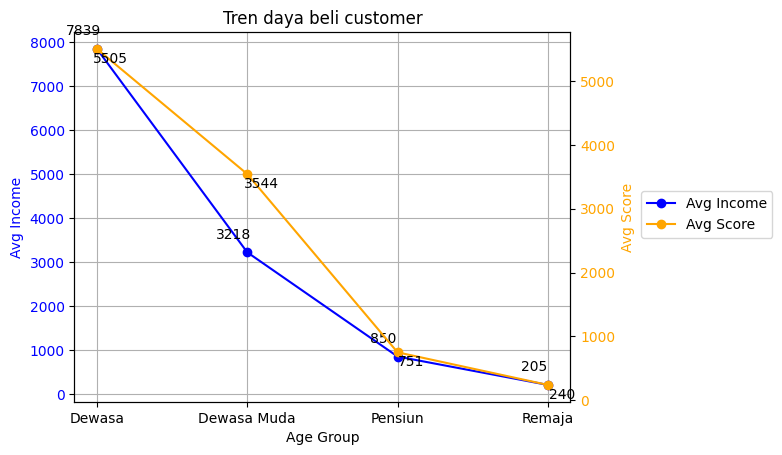


Dari hasil visualisasi tersebut dapat diketahui bahwa golongan usia dewasa memiliki 
kemampuan daya beli yang jauh lebih tinggi dibandingkan dengan golongan usia lain 
ini bisa disimpulkan bahwa pelanggan dengan kategori usia dewasa lebih sering 
melakukan pengeluaran di banding dengan kategori lainnya 



In [35]:
fig, ax1 = plt.subplots()

# Plot avg_income
ax1.plot(daya_beli_customer['kategori_usia'], daya_beli_customer['total_pendapatan_tahunan'], marker='o', color='blue', label='Avg Income')
ax1.set_xlabel('Age Group')
ax1.set_ylabel('Avg Income', color='blue')
ax1.tick_params(axis='y', labelcolor='blue')

# Tambahkan label untuk setiap titik avg_income
for i, txt in enumerate(daya_beli_customer['total_pendapatan_tahunan']):
    ax1.annotate(f'{txt}', (daya_beli_customer['kategori_usia'][i], daya_beli_customer['total_pendapatan_tahunan'][i]), 
                textcoords="offset points", xytext=(-10, 10), ha='center', color='black')

# Create a second y-axis for avg_score
ax2 = ax1.twinx()
ax2.plot(daya_beli_customer['kategori_usia'], daya_beli_customer['total_pengeluaran_tahunan'], marker='o', color='orange', label='Avg Score')
ax2.set_ylabel('Avg Score', color='orange')
ax2.tick_params(axis='y', labelcolor='orange')

# Tambahkan label untuk setiap titik avg_score
for i, txt in enumerate(daya_beli_customer['total_pengeluaran_tahunan']):
    ax2.annotate(f'{txt}', (daya_beli_customer['kategori_usia'][i], daya_beli_customer['total_pengeluaran_tahunan'][i]), 
                textcoords="offset points", xytext=(10, -10), ha='center', color='black')

# Add title and grid
plt.title('Tren daya beli customer')
ax1.grid(True)

# Add legends
fig.legend(loc='center left', bbox_to_anchor=(1, 0.5))

plt.show()

print("""
Dari hasil visualisasi tersebut dapat diketahui bahwa golongan usia dewasa memiliki 
kemampuan daya beli yang jauh lebih tinggi dibandingkan dengan golongan usia lain 
ini bisa disimpulkan bahwa pelanggan dengan kategori usia dewasa lebih sering 
melakukan pengeluaran di banding dengan kategori lainnya 
""")

### **14. Analisis persentase kategori usia dan jenis kelamin**
---
pada kode program berikut ini kita akan membuat persentase untuk kategori usia berdasarkan jenis kelamin

In [36]:
query = """
SELECT * FROM gender_percentage_by_age_group
"""

persentase_kategori_usia = db.execute_query(query)

# Jika result sudah berupa DataFrame
if persentase_kategori_usia is not None:
    print(persentase_kategori_usia.head())

  kategori_usia  Gender persentase
0        Dewasa  Female      59.50
1        Dewasa    Male      40.50
2   Dewasa Muda  Female      56.90
3   Dewasa Muda    Male      43.10
4       Pensiun  Female      35.29


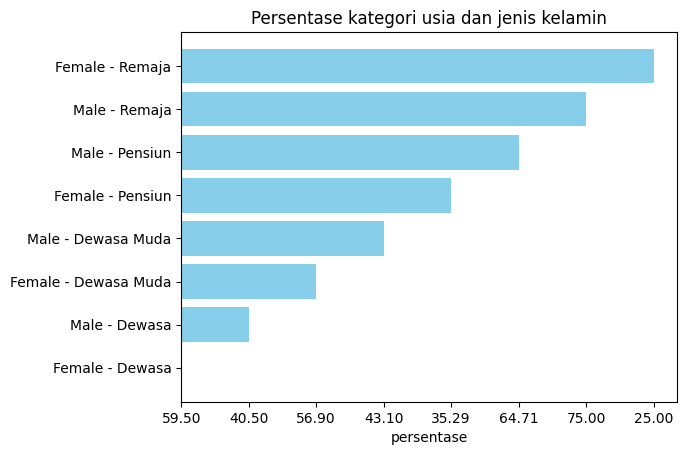


Dari hasil visualisasi diatas dapat diketahui bahwa pelanggan dengan jenis kelamin perempuan dan golongan usia remaja 
memiliki persentase yang lebih besar dibandingan dengan golongan usia lain nya 



In [37]:
# Data untuk grouped bar chart
categories = persentase_kategori_usia["kategori_usia"].unique()
male_counts = persentase_kategori_usia[persentase_kategori_usia["Gender"] == "Male"].set_index("kategori_usia")["persentase"]
female_counts = persentase_kategori_usia[persentase_kategori_usia["Gender"] == "Female"].set_index("kategori_usia")["persentase"]

male_counts = male_counts.reindex(categories, fill_value=0)
female_counts = female_counts.reindex(categories, fill_value=0)

x = np.arange(len(categories))

# Menggabungkan kategori gender dan usia
persentase_kategori_usia["Label"] = persentase_kategori_usia["Gender"] + " - " + persentase_kategori_usia["kategori_usia"]

# Plot
plt.barh(persentase_kategori_usia["Label"], persentase_kategori_usia["persentase"], color="skyblue")
plt.xlabel("persentase")
plt.title("Persentase kategori usia dan jenis kelamin")
plt.show()

print("""
Dari hasil visualisasi diatas dapat diketahui bahwa pelanggan dengan jenis kelamin perempuan dan golongan usia remaja 
memiliki persentase yang lebih besar dibandingan dengan golongan usia lain nya 
""")

### **15.Analisis total resiko per kategori**
---
pada tahap ini kita akan membuat analisis untuk menentukan resiko untuk per kategori

In [38]:
query = """
SELECT * FROM Resiko
"""
resiko = db.execute_query(query)

# Jika result sudah berupa DataFrame
if resiko is not None:
    print(resiko.head())

   CustomerID  Gender  Age  Annual Income (k$)  Spending Score (1-100)  \
0           1    Male   19                  15                      39   
1           2    Male   21                  15                      81   
2           3  Female   20                  16                       6   
3           4  Female   23                  16                      77   
4           5  Female   31                  17                      40   

  kategori_usia total_risiko  
0   Dewasa Muda         0.60  
1   Dewasa Muda         0.60  
2   Dewasa Muda         0.60  
3   Dewasa Muda         0.60  
4        Dewasa         0.60  


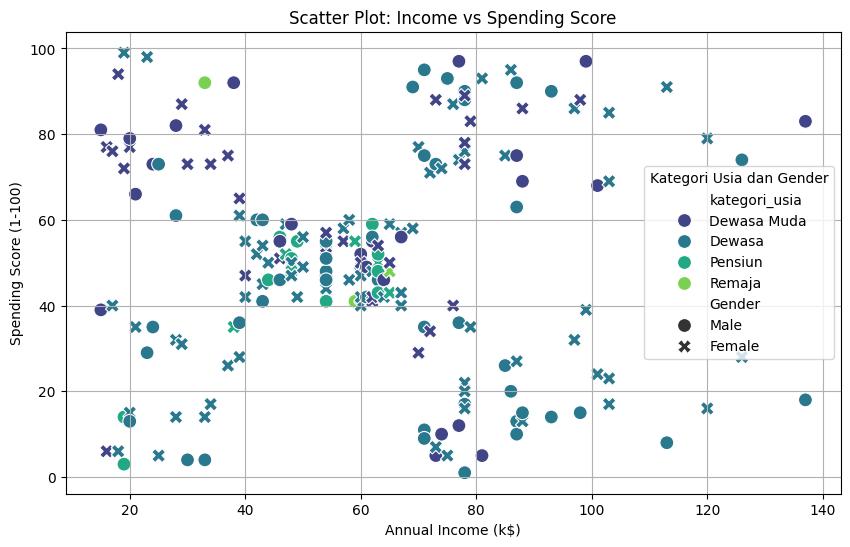

In [39]:
# Scatter plot dengan seaborn
plt.figure(figsize=(10, 6))
sns.scatterplot(
    data=resiko,
    x='Annual Income (k$)',
    y='Spending Score (1-100)',
    hue='kategori_usia',
    style='Gender',
    palette='viridis',
    s=100
)
plt.title('Scatter Plot: Income vs Spending Score')
plt.xlabel('Annual Income (k$)')
plt.ylabel('Spending Score (1-100)')
plt.legend(title='Kategori Usia dan Gender')
plt.grid(True)
plt.show()

berdasarkan visualisasi diatas ternyata hubungan antara spending score dan annual income tidak ada korelasi sama sekali sehingga dalam hal ini spending dan annual tidak ada hubungan sama sekali dalam hal ini

### **16.Analisis menentukan diskon terbaik untuk masing-masing kategori usia**
---
pada tahap ini kita akan membuat analisis untuk menentukan diskon terbaik untuk maisng-maisng kategori usia 

In [40]:
query = """
SELECT * FROM diskon;
"""

diskon = db.execute_query(query)

# Jika result sudah berupa DataFrame
if diskon is not None:
    print(diskon.head())

   CustomerID  Gender  Age  Annual Income (k$)  Spending Score (1-100)  \
0           1    Male   19                  15                      39   
1           2    Male   21                  15                      81   
2           3  Female   20                  16                       6   
3           4  Female   23                  16                      77   
4           5  Female   31                  17                      40   

  kategori_usia prioritas_diskon diskon  
0   Dewasa Muda           0.7200  36.00  
1   Dewasa Muda           0.7200  36.00  
2   Dewasa Muda           0.7400  37.00  
3   Dewasa Muda           0.7400  37.00  
4        Dewasa           0.6800  34.00  


### **17. Analisis segmentasi diskon berdasarkan kategori usia dan jenis kelamin** 
---
pada tahap ini kita akan membuat analisis untuk segmentasi penentuan diskon terbaik dan prioritas diskon untuk kategori usia dan gender 

In [41]:
query = """
SELECT * FROM segmentasi_diskon;
"""
segmentasi_diskon = db.execute_query(query)

if segmentasi_diskon is not None:
    print(segmentasi_diskon.head)

<bound method NDFrame.head of      CustomerID  Gender  Age  Annual Income (k$)  Spending Score (1-100)  \
0            39  Female   36                  37                      26   
1             7  Female   35                  18                       6   
2           141  Female   57                  75                       5   
3            15    Male   37                  20                      13   
4           173    Male   36                  87                      10   
..          ...     ...  ...                 ...                     ...   
195         110    Male   66                  63                      48   
196          34    Male   18                  33                      92   
197         115  Female   18                  65                      48   
198          92    Male   18                  59                      41   
199          66    Male   18                  48                      59   

    kategori_usia income_group         discount_level  
0

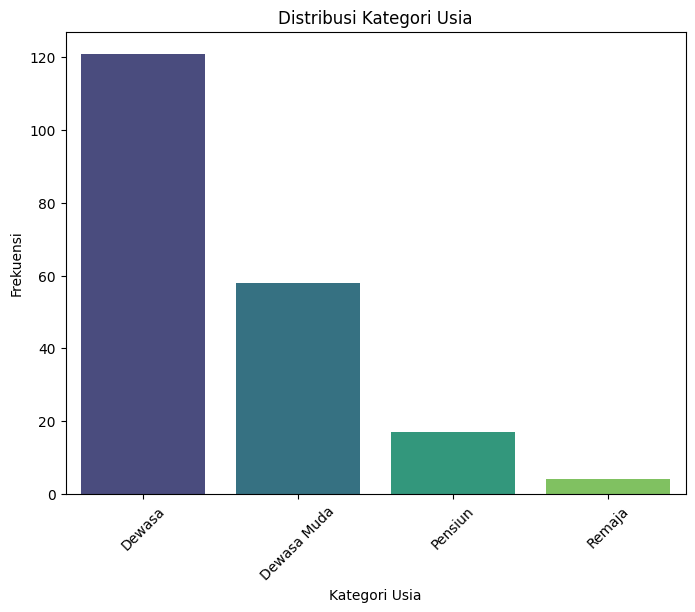

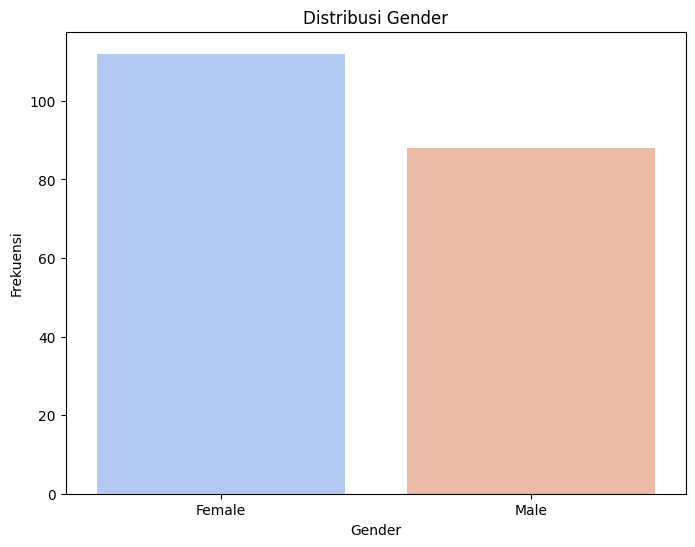

In [42]:
# Visualisasi Histogram Kategori
plt.figure(figsize=(8, 6))

sns.countplot(x="kategori_usia", data=segmentasi_diskon, palette="viridis")
plt.title("Distribusi Kategori Usia")
plt.xlabel("Kategori Usia")
plt.ylabel("Frekuensi")
plt.xticks(rotation=45)
plt.show()

# Histogram untuk Gender
plt.figure(figsize=(8, 6))

sns.countplot(x="Gender", data=segmentasi_diskon, palette="coolwarm")
plt.title("Distribusi Gender")
plt.xlabel("Gender")
plt.ylabel("Frekuensi")
plt.show()

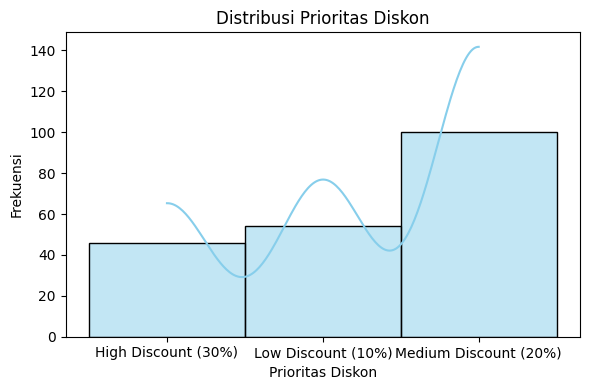

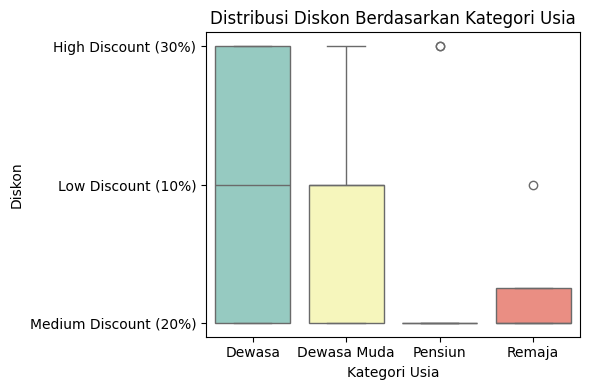

In [43]:
# 3. Distribusi prioritas diskon
plt.figure(figsize=(6, 4))
sns.histplot(segmentasi_diskon['discount_level'], kde=True, bins=5, color='skyblue')
plt.title('Distribusi Prioritas Diskon')
plt.xlabel('Prioritas Diskon')
plt.ylabel('Frekuensi')
plt.tight_layout()
plt.show()

# 4. Box plot diskon berdasarkan kategori usia
plt.figure(figsize=(6, 4))
sns.boxplot(x='kategori_usia', y='discount_level', data=segmentasi_diskon, palette='Set3')
plt.title('Distribusi Diskon Berdasarkan Kategori Usia')
plt.xlabel('Kategori Usia')
plt.ylabel('Diskon')
plt.tight_layout()

### **18 Visualisasi data pie chart**
---
pada tahap selanjutnya kita akan memembuat visualisasi data pie chart untuk data dengan tipe data kategori dan mencoba untuk mencari insight 

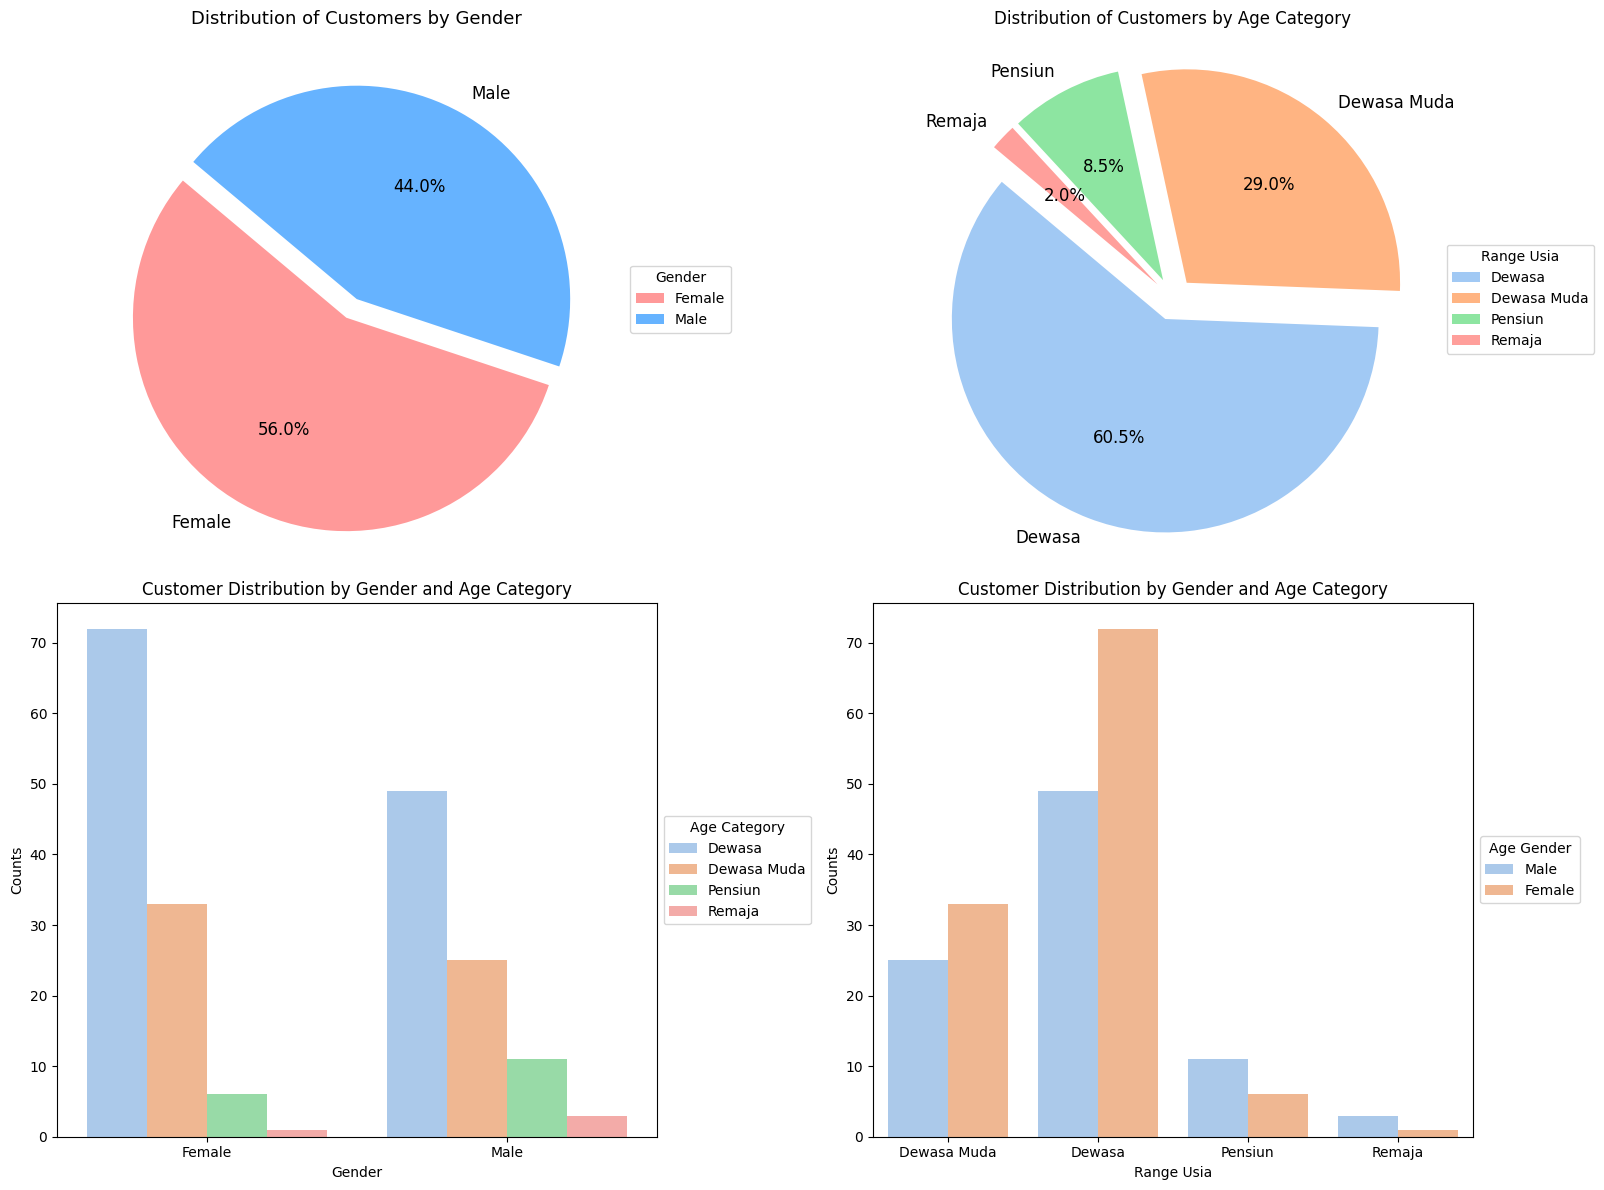

In [44]:
age_category_conts = df['kategori_usia'].value_counts()

fig, axes = plt.subplots(2, 2, figsize=(16,12))

gender_explode = [0.1, 0]
gender_counts = df['Gender'].value_counts()

wedges, texts, autotexts = axes[0,0].pie(
    gender_counts, labels=gender_counts.index,  autopct='%1.1f%%', startangle=140, 
    colors=['#ff9999','#66b3ff'], textprops={'fontsize': 12}, explode=gender_explode)

axes[0, 0].set_title('Distribution of Customers by Gender', fontsize=13, fontfamily='sans serif')
axes[0, 0].legend(wedges, gender_counts.index, title="Gender", loc="center left", bbox_to_anchor=(1, 0, 0.5, 1), fontsize=10)

# Pie Chart untuk Kategori Usia
age_category_explode = [0.1, 0.1, 0.1, 0.1]
age_category_counts = df['kategori_usia'].value_counts()
wedges, texts, autotexts = axes[0, 1].pie(
    age_category_counts, labels=age_category_counts.index, autopct='%1.1f%%', startangle=140,
    textprops={'fontsize': 12}, colors=sns.color_palette("pastel"), explode=age_category_explode)

axes[0, 1].set_title('Distribution of Customers by Age Category')
axes[0, 1].legend(wedges, age_category_counts.index, title="Range Usia", loc="center left", bbox_to_anchor=(1, 0, 0.5, 1), fontsize=10)


# Bar Chart untuk Gender dan Kategori Usia
# Group by Gender dan AgeCategory untuk pie chart dan bar chart
grouped_df = df.groupby(['Gender', 'kategori_usia']).size().reset_index(name='Counts')
sns.barplot(x='Gender', y='Counts', hue='kategori_usia', data=grouped_df, palette='pastel', ax=axes[1, 0])
axes[1, 0].set_title('Customer Distribution by Gender and Age Category')
axes[1, 0].set_xlabel('Gender')
axes[1, 0].set_ylabel('Counts')
axes[1, 0].legend(title='Age Category', loc="center left", bbox_to_anchor=(1, 0, 0.5, 1), fontsize=10)

sns.countplot(x = 'kategori_usia', data = df, hue='Gender', palette='pastel', ax=axes[1, 1])
axes[1, 1].set_title('Customer Distribution by Gender and Age Category')
axes[1, 1].set_xlabel('Range Usia')
axes[1, 1].set_ylabel('Counts')
axes[1, 1].legend(title='Age Gender', loc="center left", bbox_to_anchor=(1, 0, 0.5, 1), fontsize=10)

plt.tight_layout()
plt.show()

# 3. Build Model K-Means and Fuzzy C-Means 
---
setelah kita mendapatkan insight yang cukup dari proses eda dan data kita sudah bersih pada tahap sebelumnya, selanjutnya kita akan membuat model machine learning dan preprocessing data untuk menghasilkan model yang baik serta dapat digunakan pada lingkungan produksi.

kita akan menggunakan 2 model sebagai perbandingan yaitu model KMeans (hard clustering) dan fuzzy c-means (soft clustering) sehingga nanti nya kita akan membandingkan mana model yang lebih baik yang bisa kita gunakan untuk ke tahap deployement nanti nya 

In [45]:
# import library yang dibutuhkan 
from sklearn.preprocessing import StandardScaler, LabelEncoder 

# import library untuk transformasi dan preprocessing data
from sklearn.cluster import KMeans                             

# import library untuk model soft-clustering
from fcmeans import FCM                                        

# library untuk model fuzzy c-means 
from yellowbrick.cluster import SilhouetteVisualizer, KElbowVisualizer 

### 3.1 Preprocessing data
---
pada tahap ini kita akan melakukan transformasi data untuk kolom dengan rentang nilai yang jauh menggunakan standarscaler untuk menyamakan rentang nilai antara 0-1 dan label encoder untu merubah label gender dari tipe data kategorik menjadi numerik, dalam kasus ini kita tidak akan menggunakan kolom kategori usia sehingga kita bisa menghapus kolom tersebut bersama dengan kolom CustomerID

In [46]:
data = df.copy()

# menghapus kolom customer id dan kategori usia 
data.drop(['CustomerID','kategori_usia'], axis=1, inplace=True)

Label = LabelEncoder()

data['Gender'] = Label.fit_transform(data['Gender'])

scaler = StandardScaler()

Gender = data['Gender']
data.drop('Gender', axis=1)

data = pd.DataFrame(scaler.fit_transform(data), columns = data.columns)
data['Gender'] = Gender
print(data.head())

print('''\n
Dengan melakukan transformasi dengan menggunakan standard scaler 
nilai rentang dari setiap fitur kini tidak lagi terlalu jauh 
dan berada di angka 1 dan 0 sehingga secara keseluruhan datasheet
yang kita punya sudah memiliki isi fitur yang baik
''')

   Gender       Age  Pendapatan_Tahunan  Skor_Pengeluaran
0       1 -1.424569           -1.687429         -0.440591
1       1 -1.281035           -1.687429          1.220525
2       0 -1.352802           -1.687429         -1.745755
3       0 -1.137502           -1.687429          1.062324
4       0 -0.563369           -1.687429         -0.401041


Dengan melakukan transformasi dengan menggunakan standard scaler 
nilai rentang dari setiap fitur kini tidak lagi terlalu jauh 
dan berada di angka 1 dan 0 sehingga secara keseluruhan datasheet
yang kita punya sudah memiliki isi fitur yang baik



### 3.2 Penentuan jumlah k optimal dengan teknik elbow
---
pada tahap ini kita akan mencoba untuk mencari nilai k yang optimal untuk model K-Means menggunakan teknik elbow 
* Koefisien silhouette dihitung menggunakan persamaan:

$$
\frac{b-a}{\max{(a, b)}},
$$

* dengan $a$ adalah jarak **intra-cluster**, yaitu jarak antar elemen dalam satu cluster, dan $a$ adalah jarak **inter-cluster**, yaitu jarak suatu elemen dengan elemen lain yang tidak dalam satu cluster yang sama.

* Nilai koefisien silhouette berada pada rentang antara -1 sampai 1. Jika koefisien silhouette semakin mendekati 1, maka bisa dikatakan cluster yang dihasilkan sudah optimal.

* Kita bisa menggunakan fungsi `silhouette_score` dari scikit-learn.

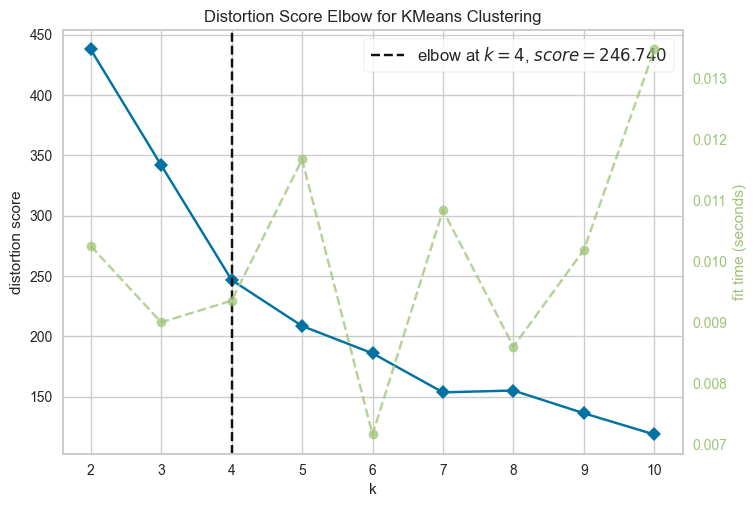

<Axes: title={'center': 'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [47]:
wcss = []

for i in range(1,11):
    model = KMeans(n_clusters= i, init='k-means++', random_state=0)
    model.fit(data)
    wcss.append(model.inertia_)

# Good part of Yellowbrick
model = KMeans()
visualizer = KElbowVisualizer(model, k=(2,11), metric='distortion')
# Fit and show the performance with dataset
visualizer.fit(data)
visualizer.show()

### 3.3 Buat model K-means 
--- 
setelah kita mengetahui nilai k yang optimal untuk model kita, tahap selanjutnya adalah membuat model k-means dan melihat hasil nya 

### 3.1 Visualisasi untuk melihat penyebaran klaster pelanggan pada data mall customer 
---
pada bagian ini kita akan melihat hasil dari analisis customer segmentation dengan memanfaatkan visulisasi boxplot

In [73]:
# membuat variabel untuk menguji data dengan nilai k berjumlah 5 
k_means = KMeans(n_clusters=4).fit(data)

# simpan kategori hasil prediski ke variabel data 
df['klaster'] = k_means.labels_

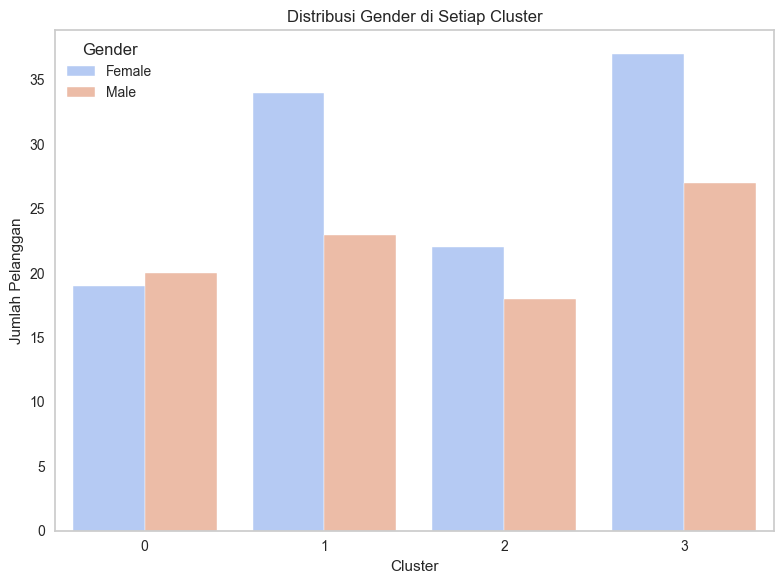


dari hasil visualisasi diatas kita dapat mengetahui bahwa customer dengan jenis kelamin perempuan 
lebih signifikan melakukan transaksi dibandingkan dengan laki-laki di berbagai golongan usia, 
sehingga kita bisa fokus pada customer perempuan sebagai target kita



In [74]:
# Bar plot
gender_distribution = df.groupby(['klaster', 'Gender']).size().reset_index(name='count')
plt.figure(figsize=(8, 6))
sns.barplot(
    x='klaster',
    y='count',
    hue='Gender',
    data=gender_distribution,
    palette='coolwarm'
)
plt.title('Distribusi Gender di Setiap Cluster')
plt.xlabel('Cluster')
plt.ylabel('Jumlah Pelanggan')

# Menghilangkan grid
plt.grid(False)

plt.tight_layout()
plt.show()

print("""
dari hasil visualisasi diatas kita dapat mengetahui bahwa customer dengan jenis kelamin perempuan 
lebih signifikan melakukan transaksi dibandingkan dengan laki-laki di berbagai golongan usia, 
sehingga kita bisa fokus pada customer perempuan sebagai target kita
""")


### 3.2 Model Interpretation
berikut ini kita akan melakukan visualisasi scatter plot untuk mengelompokan hasil analisis yang sudah kita buat kedalam cluster yang sudah kita tentukan sebelum nya dengan menggunakan teknik metode elbow.

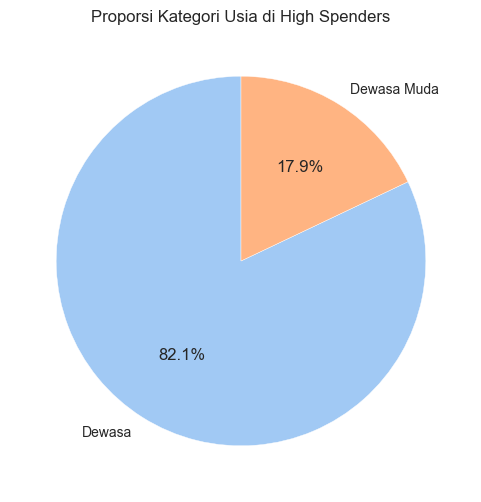

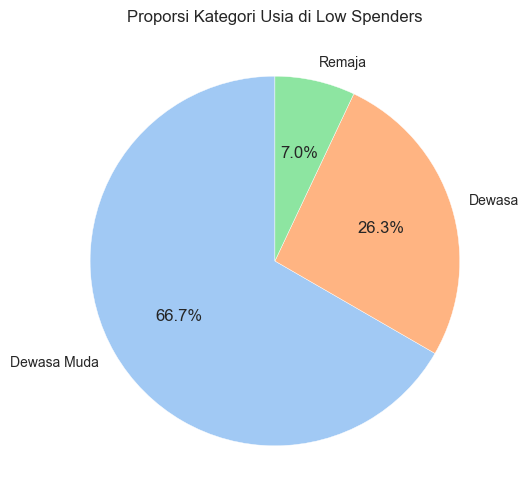

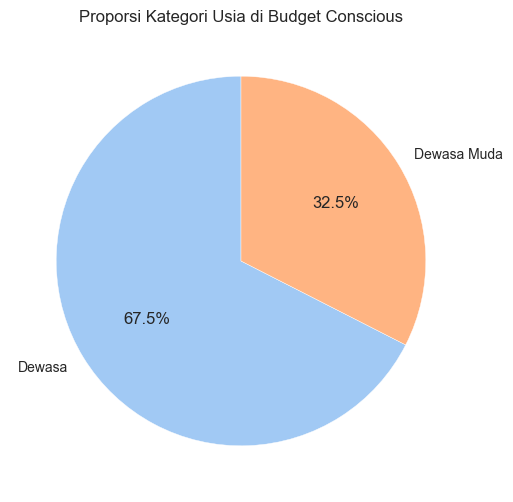

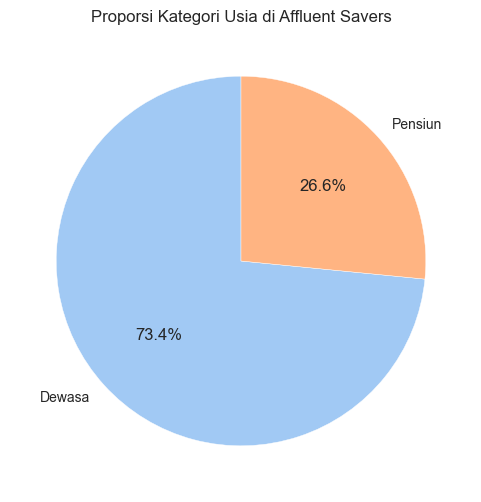

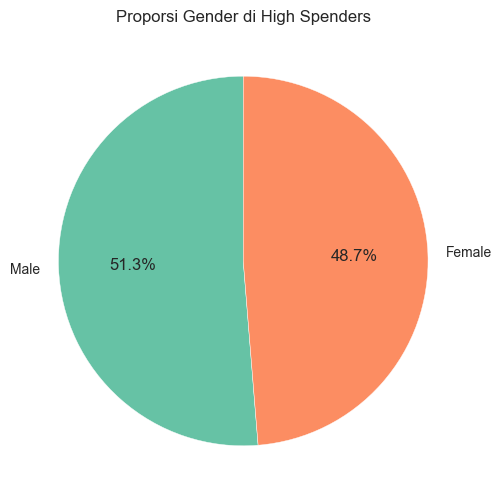

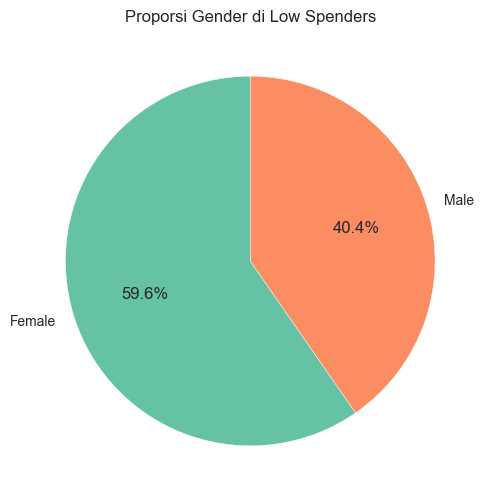

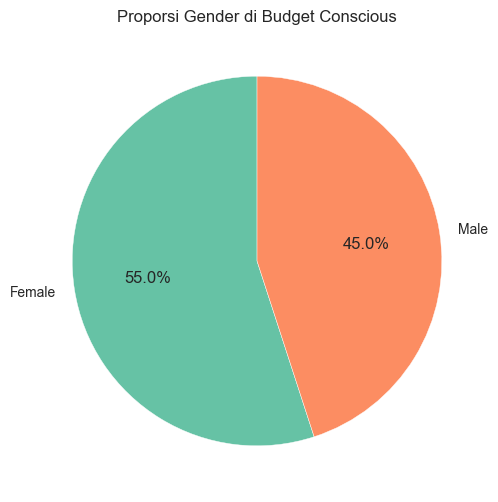

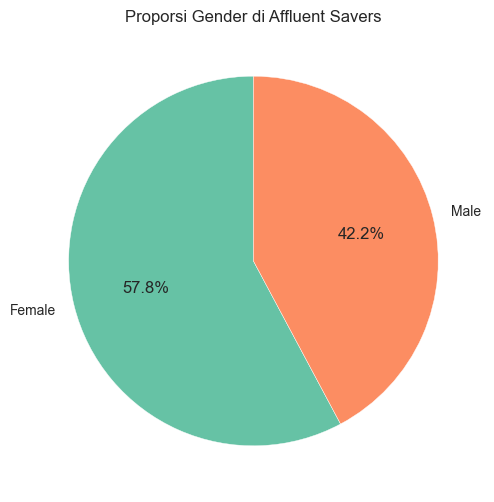



1.  pada visualisasi proporsi kategori usia di cluster 0 : dapat diketahui bahwa customer baik pria atau wanita untuk kategori usia dewasa memiliki persentase sebesar 70.7 % itu artinya cluster ini merupakan customer aktif dibandingan dengan golongan usia dewasa muda dan remaja sedangkan golongan usia pensiun di cluster ini menempati persentase 29.3 % yang menjadikan nya sebagai customer tertinggi ke dua untuk cluster 0.

2. pada visualisasi di cluster 1 : dapat diketahui bahwa untuk kategori pelanggan dengan pembelian rendah ada beberapa tipe golongan usia yaitu dewasa muda sebesar 51.1 %, dewasa 42.6 % dan remaja 6.4 % yang mengindikasikan bahwa golongan usia ini sedikit melakukan transaksi, terutama pada kategori dewasa muda dan juga remaja.

3. Pada visualisasi di cluster 2 : untuk budget conscious kategori dewasa memiliki persentase 88.2 % dan dewasa sekitar 11.8 %.

4.  pada semua golongan cluster untuk segmentasi pelanggan berdasarkan jenis kelamin : ternyata perempuan  memili

In [75]:
# Ide nama untuk setiap cluster
cluster_names = {
    0: 'High Spenders',
    1: 'Low Spenders',
    2: 'Budget Conscious',
    3: 'Affluent Savers',
}

# Atur gaya plot
sns.set_palette("pastel")
sns.set_style("whitegrid")

# Buat pie chart untuk kategori usia dalam setiap cluster
for cluster in sorted(df['klaster'].unique()):
    cluster_data = df[df['klaster'] == cluster]
    
    # Distribusi kategori usia
    age_category_distribution = cluster_data['kategori_usia'].value_counts()
    plt.figure(figsize=(6, 6))
    age_category_distribution.plot.pie(
        autopct='%1.1f%%',
        startangle=90,
        colors=sns.color_palette('pastel'),
        title=f'Proporsi Kategori Usia di {cluster_names.get(cluster, f"Cluster {cluster}")}'
    )
    plt.ylabel('')  # Hilangkan label sumbu Y
    plt.show()

# Buat pie chart untuk gender dalam setiap cluster
for cluster in sorted(df['klaster'].unique()):
    cluster_data = df[df['klaster'] == cluster]
    
    # Distribusi gender
    gender_distribution = cluster_data['Gender'].value_counts()
    plt.figure(figsize=(6, 6))
    gender_distribution.plot.pie(
        autopct='%1.1f%%',
        startangle=90,
        colors=sns.color_palette('Set2'),
        title=f'Proporsi Gender di {cluster_names.get(cluster, f"Cluster {cluster}")}'
    )
    plt.ylabel('')  # Hilangkan label sumbu Y
    plt.show()



print("""

1.  pada visualisasi proporsi kategori usia di cluster 0 : dapat diketahui bahwa customer baik pria atau wanita untuk kategori usia dewasa memiliki persentase sebesar 70.7 % itu artinya cluster ini merupakan customer aktif dibandingan dengan golongan usia dewasa muda dan remaja sedangkan golongan usia pensiun di cluster ini menempati persentase 29.3 % yang menjadikan nya sebagai customer tertinggi ke dua untuk cluster 0.

2. pada visualisasi di cluster 1 : dapat diketahui bahwa untuk kategori pelanggan dengan pembelian rendah ada beberapa tipe golongan usia yaitu dewasa muda sebesar 51.1 %, dewasa 42.6 % dan remaja 6.4 % yang mengindikasikan bahwa golongan usia ini sedikit melakukan transaksi, terutama pada kategori dewasa muda dan juga remaja.

3. Pada visualisasi di cluster 2 : untuk budget conscious kategori dewasa memiliki persentase 88.2 % dan dewasa sekitar 11.8 %.

4.  pada semua golongan cluster untuk segmentasi pelanggan berdasarkan jenis kelamin : ternyata perempuan  memiliki persentase sebesar 59.1 % dibandingankan dengan laki-laki yang hanya berjumlah 40.9 % ini mengindikasikan bahwa customer perempuan dari berbagai golongan usia merupakan pelanggan dengan status aktif berbelanja 
""")

### Cek hasil klaster K-means dengan menggunakan teknik PCA

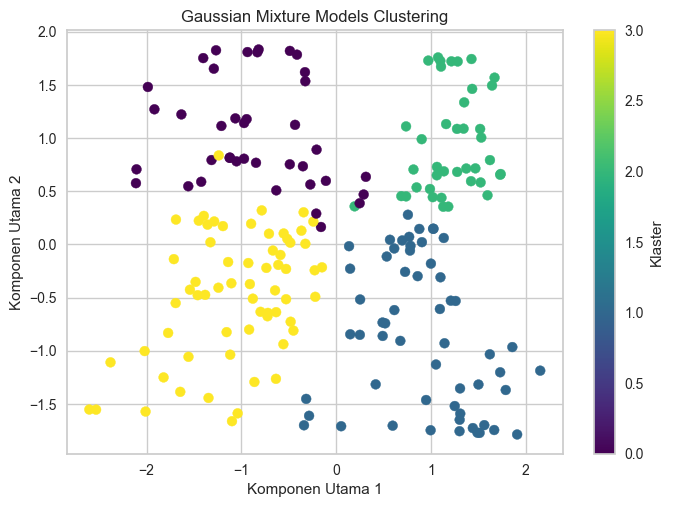

In [130]:
from sklearn.decomposition import PCA 

kmeans_labels = k_means.predict(data)

pca = PCA(n_components=2)
data_pca = pca.fit_transform(data)

plt.scatter(data_pca[:, 0], data_pca[:, 1], c=kmeans_labels, cmap='viridis', s=50)
plt.title('Gaussian Mixture Models Clustering')
plt.xlabel('Komponen Utama 1')
plt.ylabel('Komponen Utama 2')
plt.colorbar(label='Klaster')
plt.show()

### 3.3 Pengujian cluster untuk annual income dengan spending score 
---
pada tahap ini kita akan menguji hubungan antara kolom annual income dengan spending score dan melihat hasil dari analisis cluster tersebut

In [76]:
customer = df.iloc[:, [2,3]]
customer_x = np.array(customer)

Kmeans = KMeans(n_clusters= 4, init='k-means++', n_init= 1, random_state=10)
Kmeans.fit(customer_x)

customer['cluster'] = Kmeans.labels_
customer.head()

,Age,Pendapatan_Tahunan,cluster
0,19,19,1
1,21,19,1
2,20,19,1
3,23,19,1
4,31,19,1


#### pengukuran model dengan menggunakan silhoeutte score dan boundin score

In [78]:
from sklearn.metrics import silhouette_score, davies_bouldin_score

kmeans = KMeans(n_clusters = 4, init='k-means++', n_init= 1, random_state=10)
labels = kmeans.fit_predict(customer)

# Hitung silhouette score dari datasheet yang sudah di normalisasi 
sil_score = silhouette_score(data, labels)
print(f'silhouette score : {sil_score:.3f}')

# Hitung Davies-Boundin Index
db_index = davies_bouldin_score(data, labels)
print(f'Davies-Boundin Index : {db_index:.3f}')

silhouette score : 0.205
Davies-Boundin Index : 1.908


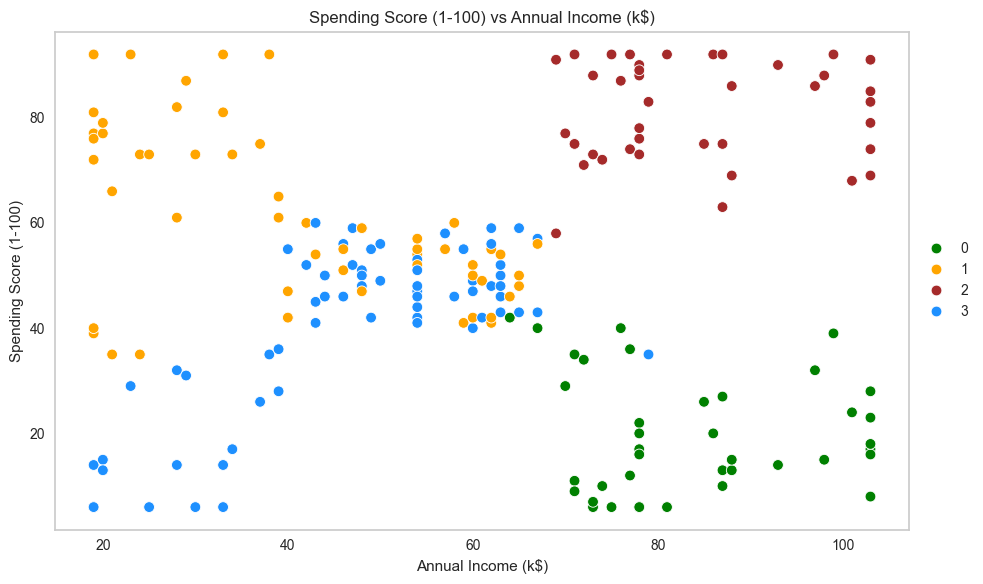

In [79]:
# Asumsikan df sudah didefinisikan dan berisi data yang diperlukan
plt.figure(figsize=(10,6))
sns.scatterplot(x='Pendapatan_Tahunan', y='Skor_Pengeluaran', hue='klaster',
                palette=['green','orange','brown','dodgerblue'], legend='full', data=df, s=60)
plt.xlabel('Annual Income (k$)')
plt.ylabel('Spending Score (1-100)')
plt.title('Spending Score (1-100) vs Annual Income (k$)')

# Pindahkan legend ke sebelah kiri
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

plt.tight_layout()

# Menghilangkan grid
plt.grid(False)
plt.show()

#### **3.3.1 Insight dari analisis dengan (Hard Clustering)**
---
pada bagian ini kita akan mencoba untuk memetakan hasil dari analisis setiap cluster dan mengambil kesimpulan pola dari hasil analisis masing-masing cluster, sehingga nanti nya kita bisa mengetahui perilaku customer berdasarkan umur, pendapatan dan skor pengeluaran

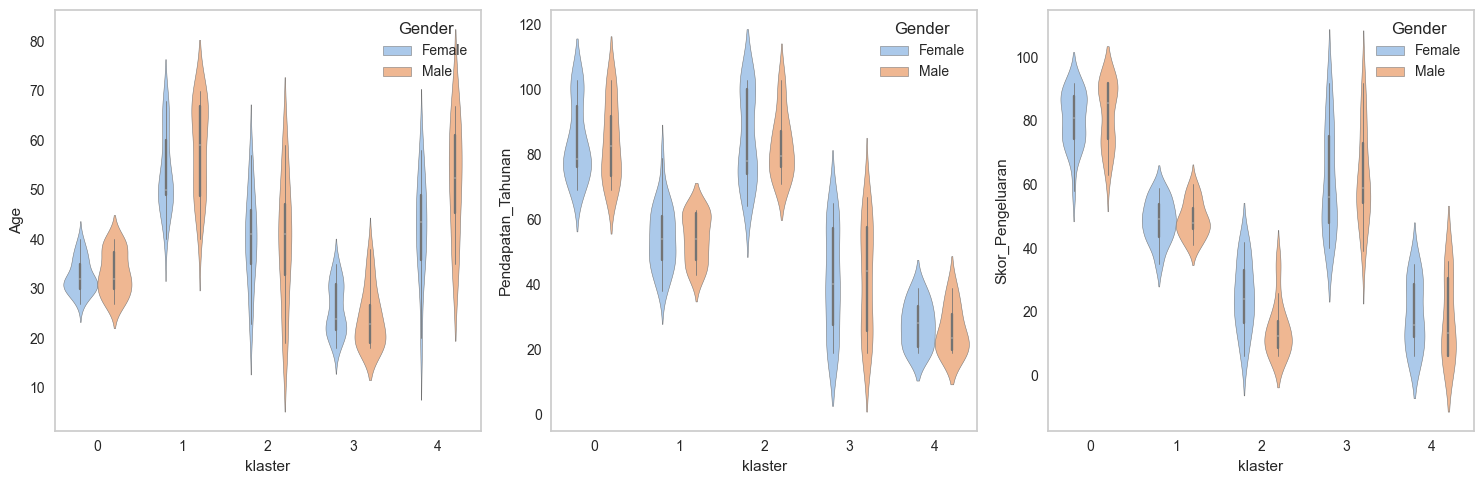

In [55]:
fig, ax = plt.subplots(1,3, figsize=(15,5))

sns.violinplot(x ='klaster', y ='Age', data = df, hue='Gender', ax=ax[0])
sns.violinplot(x ='klaster', y ='Pendapatan_Tahunan', data = df, hue='Gender', ax=ax[1])
sns.violinplot(x ='klaster', y ='Skor_Pengeluaran', data = df, hue='Gender', ax=ax[2])

for axis in ax:
    axis.grid(False)
    
plt.tight_layout()
plt.show()

<h3>
    <b>Insight:</b>
</h3>
<h5>
    Kesimpulan: dapat menempatkan cluster 4 untuk customer segmentation secara (Hard Clustering) sebagai <u><b>set target</b></u> untuk bisnis kita kedepan nya.
    Dengan mengetahui bahwa customer dengan rentan usia 19 - 59 tahun merupakan customer dengan jumlah yang paling banyak dengan pendapatan paling tinggi
    namun pengeluaran yang rendah kita dapat membuat strategi market dengan membuat potongan harga pada produk kita dengan harapan dapat meningkatkan daya
    beli customer pada market kita dan memperoleh profit.
</h5>
<hr>
<p>
    1.Pada cluster 1 (Blue color) sebagian customer dengan usia 35-70 tahun merupakan customer dengan jumlah tinggi.
    Memiliki pendatapan tahunan dan skor pengeluaran yang Sedang.
</p>
<p>
    2.Pada cluster 2 (Brown color) sebagian customer dengan usia 19-39 tahun merupakan customer dengan jumlah sedang.
    Memiliki pendapatan tahunan yang rendah tetapi sangat kosumtif dalam pengeluaran.
</p>
<p>
    3.Pada cluster 3 (Green color) sebagian customer dengan usia 28-39 tahun merupakan customer dengan jumlah paling sedikit.  
    Namun justru memiliki pendapatan tahunan dan pengeluaran yang tinggi.
</p>
<p>
    4.Pada cluster 4 (Red color) <b>[SET TARGET]</b> sebagian customer dengan usia 19-59 tahun merupakan customer dengan jumlah paling banyak.
    Memiliki pendapatan tahunan yang tinggi namun justru memiliki pengeluaran yang rendah.
</p>

In [56]:
CustomerGroup = df.groupby("klaster")[["Age","Pendapatan_Tahunan","Skor_Pengeluaran"]].mean()
print(CustomerGroup.head())

print('''
Berdasarkan hasil output berikut kita dapat mengetahui bahwa rata-rata segmentasi pelanggan sebagai berikut : 
1. Pada klaster 0 umur rata-rata pelanggan 32 tahun dengan pendapatan 84 k dan skor pengeluaran sebesar 81 
2. Pada klaster 1 umur rata-rata pelanggan 55 tahun dengan pendapatan 48 k dan skor pengeluaran sebesar 41 
3. Pada klaster 2 umut rata-rata pelanggan 25 tahun dengan pendapatan 26 k dan skor pengeluaran sebesar 78  
4. Pada klaster 3 umur rata-rata pelanggan 41 tahun dengan pendapatan 86 k dan skor pengeluaran sebesar 17 
5. Pada klaster 4 umut rata-rata pelanggan 27 tahun dengan pendapatan 49 k dan skor pengeluaran sebesar 44 
''')

               Age  Pendapatan_Tahunan  Skor_Pengeluaran
klaster                                                 
0        32.875000           84.000000         81.075000
1        55.638298           54.382979         48.851064
2        39.871795           83.948718         19.692308
3        25.185185           41.388889         61.962963
4        46.250000           26.950000         18.750000

Berdasarkan hasil output berikut kita dapat mengetahui bahwa rata-rata segmentasi pelanggan sebagai berikut : 
1. Pada klaster 0 umur rata-rata pelanggan 32 tahun dengan pendapatan 84 k dan skor pengeluaran sebesar 81 
2. Pada klaster 1 umur rata-rata pelanggan 55 tahun dengan pendapatan 48 k dan skor pengeluaran sebesar 41 
3. Pada klaster 2 umut rata-rata pelanggan 25 tahun dengan pendapatan 26 k dan skor pengeluaran sebesar 78  
4. Pada klaster 3 umur rata-rata pelanggan 41 tahun dengan pendapatan 86 k dan skor pengeluaran sebesar 17 
5. Pada klaster 4 umut rata-rata pelanggan 27 tahun deng

#### **3.3.2 Segmentasi pelanggan untuk klaster 0**
---
pada bagian ini kita akan melakukan analisis untuk segemntation di cluster 0 

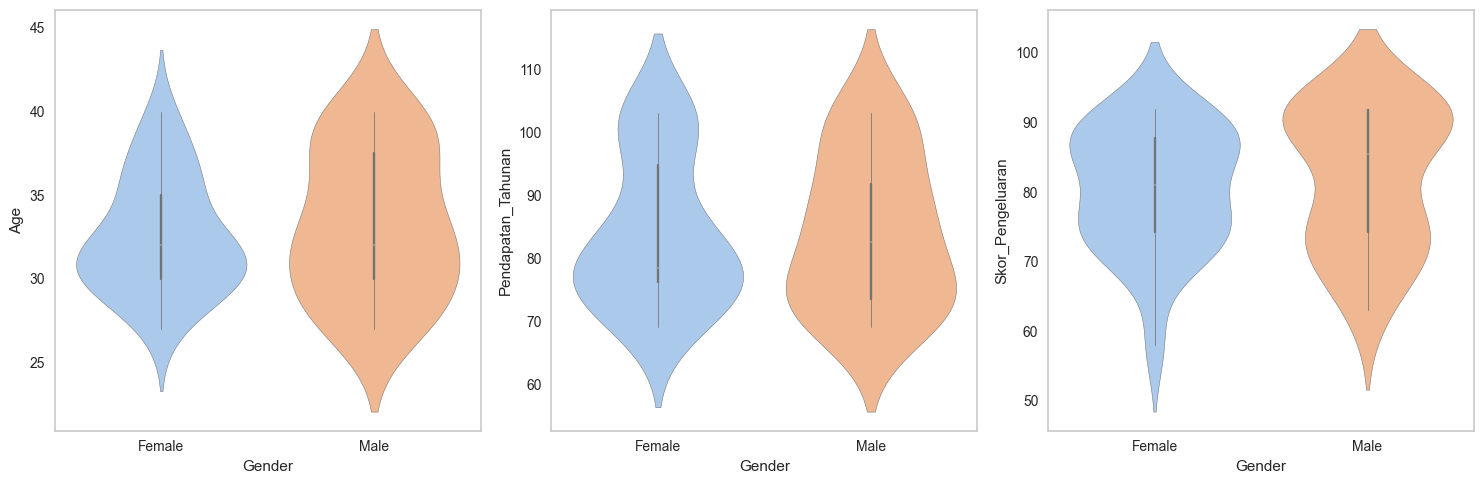

In [57]:
# Filter data untuk klaster 2
segmentation_group1 = df[df['klaster'] == 0]

fig, ax = plt.subplots(1, 3, figsize=(15, 5))

# Membuat violin plot
sns.violinplot(x='Gender', y='Age', data=segmentation_group1, hue='Gender', ax=ax[0])
sns.violinplot(x='Gender', y='Pendapatan_Tahunan', data=segmentation_group1, hue='Gender', ax=ax[1])
sns.violinplot(x='Gender', y='Skor_Pengeluaran', data=segmentation_group1, hue='Gender', ax=ax[2])

# Menghilangkan grid pada setiap subplot
for axis in ax:
    axis.grid(False)

plt.tight_layout()
plt.show()

<h3>
    <b>Insight:</b>
</h3>
<p>
Dapat dikatan kelompok pria dengan usia 35 tahun dan wanita dengan usia 39 tahun yang memiliki pendapatan dan pengeluaran yang cukup tinggi
</p>
<li>1.Pada cluster 1 customer wanita dengan usia 70 tahun lebih banyak dibandinkan dengan customer pria yang berusia 65 tahun</li>
<li>2.Kemampuan membeli customer pada cluster 1 di dominasi oleh pria dengan pendapatan $k 80
<li>3.skor pengeluaran pada cluster 1 baik customer pria maupun wanita memliki angka yang sama yaitu mencapai angka 60% dari 100%</li>

#### **3.3.3 Segmentasi pelanggan di cluster 1**
pada bagian ini kita akan melakukan analisis untuk segmentasi pelanggan di cluster 1

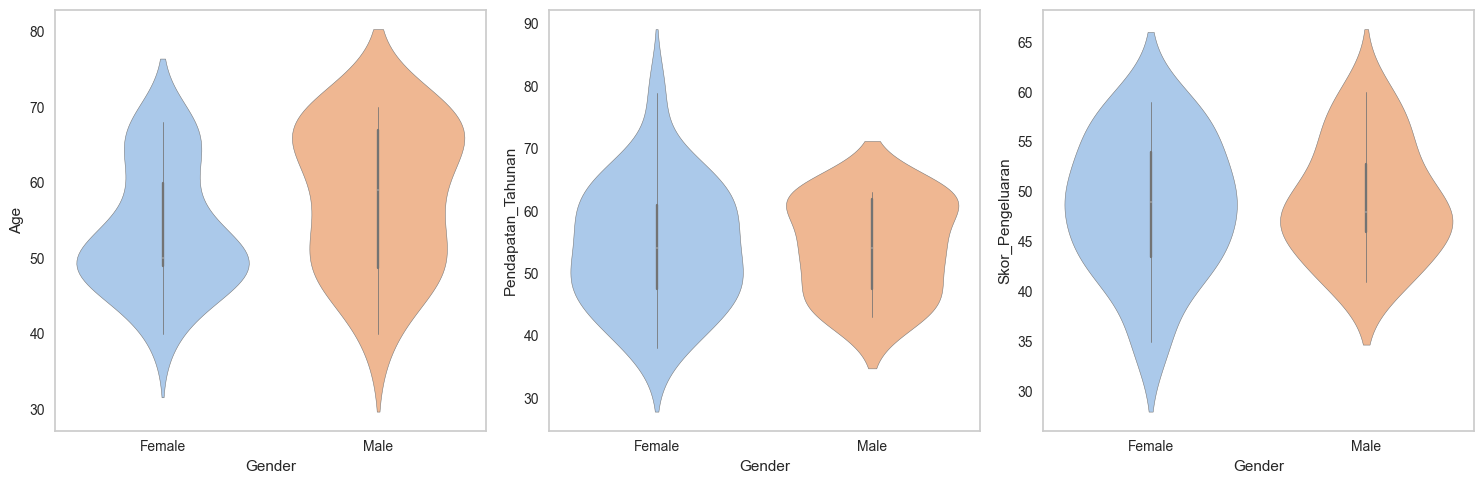

In [58]:
# Filter data untuk klaster 2
segmentation_group1 = df[df['klaster'] == 1]

fig, ax = plt.subplots(1, 3, figsize=(15, 5))

# Membuat violin plot
sns.violinplot(x='Gender', y='Age', data=segmentation_group1, hue='Gender', ax=ax[0])
sns.violinplot(x='Gender', y='Pendapatan_Tahunan', data=segmentation_group1, hue='Gender', ax=ax[1])
sns.violinplot(x='Gender', y='Skor_Pengeluaran', data=segmentation_group1, hue='Gender', ax=ax[2])

# Menghilangkan grid pada setiap subplot
for axis in ax:
    axis.grid(False)

plt.tight_layout()
plt.show()

<h3>
    <b>Insight:</b>
</h3>
<p>
Kelompok usia pria dengan umur 27-40 tahun memiliki pendapan tinggi dan wanita dengan umur 28-40 tahun memiliki pendapatan rendah. Tetapi keduanya memiliki pengeluaran yang tinggi.
</p>
<li>1.Pada cluster 2 customer wanita dan pria dewasa memiliki kategori usia 27-40 tahun</li>
<li>2.Kemampuan membeli customer pada cluster 2 di dominasi oleh pria dengan pendapatan mencapai $k 120
<li>3.skor pengeluaran pada cluster 2 baik customer pria maupun wanita memliki persentase yang tinggi mencapai angka 90%</li>

#### **3.3.4 Segmentasi pelanggan di cluster 2**
---
pada tahap ini kita akan melakukan analisis segmentasi pelanggan di cluster 2

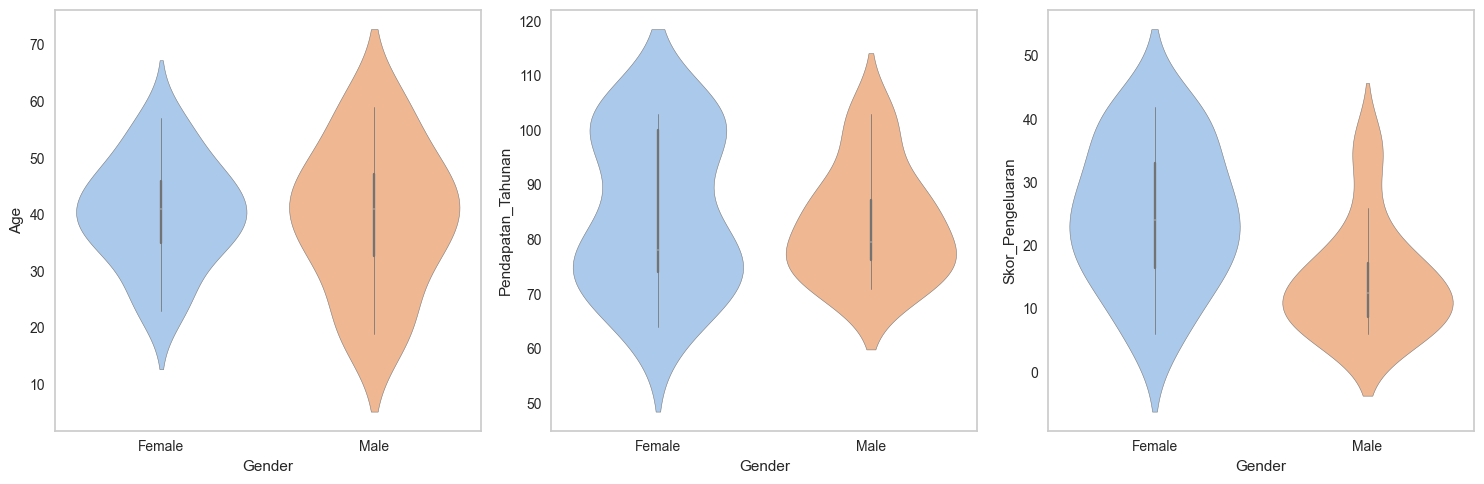

In [59]:
# Filter data untuk klaster 2
segmentation_group3 = df[df['klaster'] == 2]

fig, ax = plt.subplots(1, 3, figsize=(15, 5))

# Membuat violin plot
sns.violinplot(x='Gender', y='Age', data=segmentation_group3, hue='Gender', ax=ax[0])
sns.violinplot(x='Gender', y='Pendapatan_Tahunan', data=segmentation_group3, hue='Gender', ax=ax[1])
sns.violinplot(x='Gender', y='Skor_Pengeluaran', data=segmentation_group3, hue='Gender', ax=ax[2])

# Menghilangkan grid pada setiap subplot
for axis in ax:
    axis.grid(False)

plt.tight_layout()
plt.show()

<h3>
    <b>Insight:</b>
</h3>
<p>
Kelompok pria muda dengan umur 18-40 tahun memiliki pendapatan rendah, Kelompok wanita muda dengan umur 19-38 tahun memiliki pendapatan rendah, tetapi baik pria maupun wanita memiliki pengeluaran yang tinggi.
</p>
<li>1.Pada cluster 3 customer pria dan wanita muda memiliki kategori usia 18-40 tahun</li>
<li>2.Kemampuan membeli customer pada cluster 2 di dominasi oleh wanita dengan pendapatan mencapai $k 62
<li>3.skor pengeluaran pada cluster 3 baik customer pria maupun wanita memliki persentase yang sangat tinggi mencapai angka 100%</li>

#### **3.3.5 Segmentasi pelanggan di cluster 3**
---
pada bagian ini kita akan melakukan analisis untuk segmentasi pelanggan di cluster 3

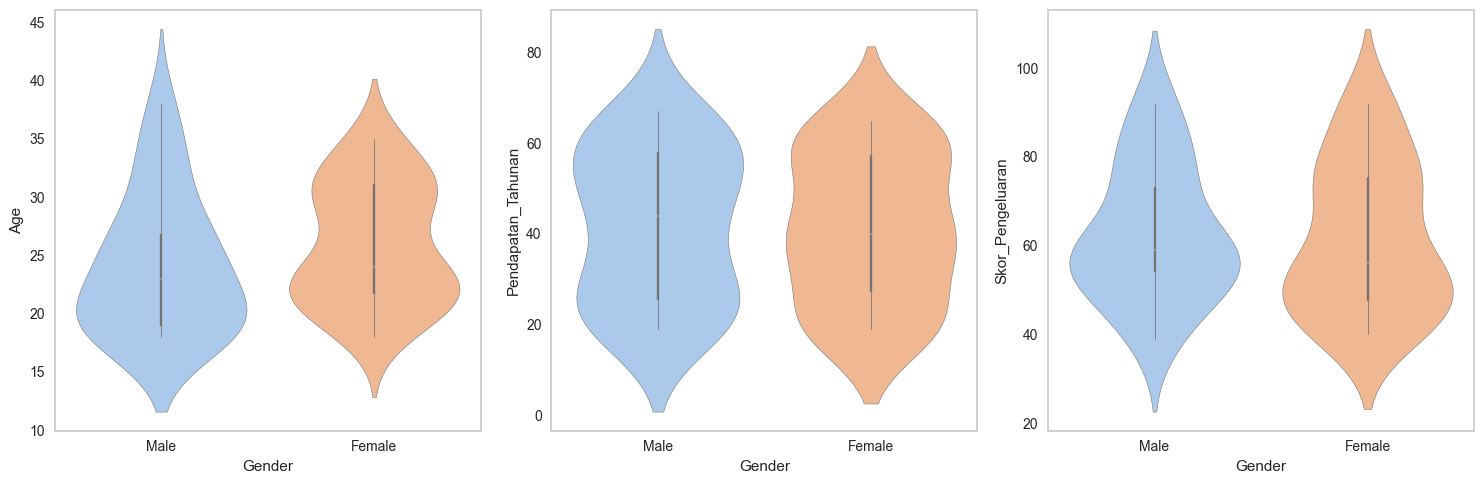

In [60]:
# Filter data untuk klaster 2
segmentation_group4 = df[df['klaster'] == 3]

fig, ax = plt.subplots(1, 3, figsize=(15, 5))

# Membuat violin plot
sns.violinplot(x='Gender', y='Age', hue='Gender', data=segmentation_group4, ax=ax[0])
sns.violinplot(x='Gender', y='Pendapatan_Tahunan', hue='Gender', data=segmentation_group4, ax=ax[1])
sns.violinplot(x='Gender', y='Skor_Pengeluaran', hue='Gender', data=segmentation_group4, ax=ax[2])

# Menghilangkan grid pada setiap subplot
for axis in ax:
    axis.grid(False)

plt.tight_layout()
plt.show()

<h3>
    <b>Insight:</b>
</h3>
<p>
Kelompok pria muda dengan umur 18-40 tahun memiliki pendapatan rendah, Kelompok wanita muda dengan umur 19-38 tahun memiliki pendapatan rendah, tetapi baik pria maupun wanita memiliki pengeluaran yang tinggi.
</p>
<li>1.Pada cluster 3 customer pria dan wanita muda memiliki kategori usia 18-40 tahun</li>
<li>2.Kemampuan membeli customer pada cluster 2 di dominasi oleh wanita dengan pendapatan mencapai $k 62
<li>3.skor pengeluaran pada cluster 3 baik customer pria maupun wanita memliki persentase yang sangat tinggi mencapai angka 100%</li>

## **3.4 Soft Clustering with Fuzzy C-Means** 
---
pada tahap ini kita akan melakukab analisis cluster dengan menggunakan fuzzy c-means untuk sof clustering dan membandingkan dengan analisis hard cluster menggunakan k-means 

In [62]:
soft_cluster_df = df.copy()

# menghapus kolom customer id dan kategori usia 
soft_cluster_df.drop(['CustomerID','kategori_usia'], axis=1, inplace=True)

Label = LabelEncoder()

soft_cluster_df['Gender'] = Label.fit_transform(data['Gender'])

scaler = StandardScaler()

Gender = data['Gender']
data.drop('Gender', axis=1)

soft_cluster_df = pd.DataFrame(scaler.fit_transform(data), columns = data.columns)
soft_cluster_df['Gender'] = Gender
soft_cluster_df.head()

,Gender,Age,Pendapatan_Tahunan,Skor_Pengeluaran
0,1,-1.424569,-1.687429,-0.440591
1,1,-1.281035,-1.687429,1.220525
2,0,-1.352802,-1.687429,-1.745755
3,0,-1.137502,-1.687429,1.062324
4,0,-0.563369,-1.687429,-0.401041


### **3.4.1 Pengukuran jumlah k optimal untuk model fuzzy c-means dengan menggunakan sihouette score** 
---
pada bagian ini kita akan membuat analisis pengukuran untuk menentukan jumlah nilai k yang optimal 

Optimal number of clusters: 4


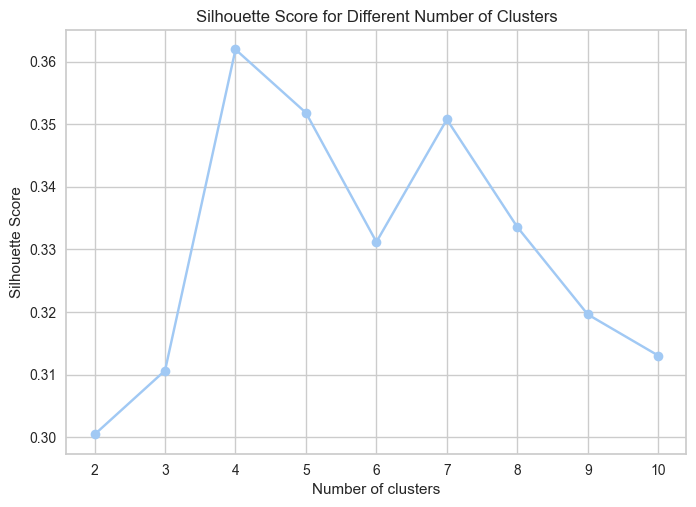

In [63]:
from sklearn.metrics import silhouette_score

# Data preparation
x = soft_cluster_df.iloc[:, :4]
x_array = np.array(x)

# Range of n_clusters to test
range_n_clusters = list(range(2, 11))

# List to store silhouette scores
silhouette_scores = []

for n_clusters in range_n_clusters:
    # Initialize FCM model
    my_model = FCM(n_clusters=n_clusters)
    my_model.fit(x_array)
    
    # Predict cluster labels
    labels = my_model.predict(x_array)
    
    # Calculate silhouette score
    score = silhouette_score(x_array, labels)
    silhouette_scores.append(score)

# Find the optimal number of clusters
optimal_n_clusters = range_n_clusters[np.argmax(silhouette_scores)]
print(f"Optimal number of clusters: {optimal_n_clusters}")

plt.plot(range_n_clusters, silhouette_scores, marker='o')
plt.xlabel('Number of clusters')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Score for Different Number of Clusters')
plt.show()

## **3.5 Build Model Soft Clustering dengan Fuzzy C-Means**
---
setelah kita mengetahui jumlah nilai k yang optimal untuk model soft clustering kita maka tahap selanjutnya adalah membuat model dengan menggunkaan jumlah nilai k yang sudah di dapatkan melalui pengukuran dengan metode silhouette Score 

In [80]:
my_model = FCM(n_clusters = 4, m = 2.0, max_iter = 150, error = 1e-5, random_state = 42)
my_model.fit(x_array)

centers = my_model.centers
labels_1 = my_model.predict(x_array)

df['C-means'] = labels_1
print(df)

     CustomerID  Gender  Age  Pendapatan_Tahunan  Skor_Pengeluaran  \
0             1    Male   19                  19                39   
1             2    Male   21                  19                81   
2             3  Female   20                  19                 6   
3             4  Female   23                  19                77   
4             5  Female   31                  19                40   
..          ...     ...  ...                 ...               ...   
195         196  Female   35                 103                79   
196         197  Female   45                 103                28   
197         198    Male   32                 103                74   
198         199    Male   32                 103                18   
199         200    Male   30                 103                83   

    kategori_usia  klaster  C-means  
0     Dewasa Muda        1        3  
1     Dewasa Muda        1        3  
2     Dewasa Muda        1        3  
3     D

### **Pengukuran model fuzzy c-means**

In [84]:
fcm  = FCM(n_clusters=4, m = 2.0, max_iter = 150, error = 1e-5, random_state=42)
fcm.fit(x_array)

fcm_labels = fcm.predict(x_array)

# Evaluasi Klasterisasi
sil_score = silhouette_score(x_array, fcm_labels)
db_index = davies_bouldin_score(x_array, fcm_labels)

print(f"Silhouette Score: {sil_score:.3f}")
print(f"Davies-Bouldin Index: {db_index:.3f}")

Silhouette Score: 0.362
Davies-Bouldin Index: 1.041


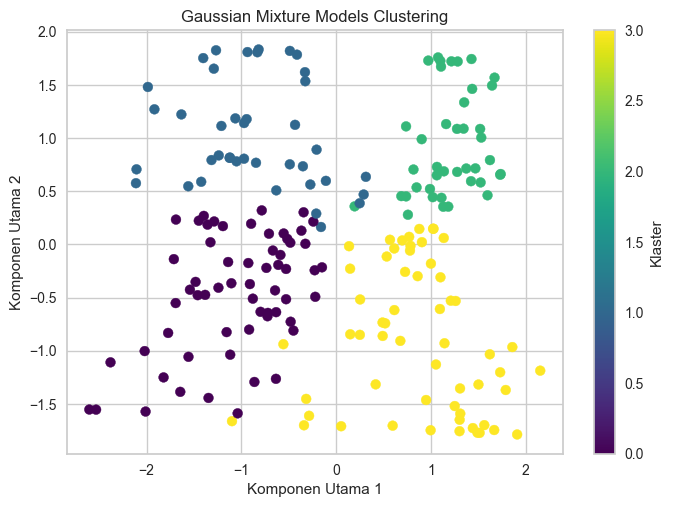

In [134]:
pca_soft_cluster = PCA(n_components=2)
df_pca_sc = pca.fit_transform(soft_cluster_df)

plt.scatter(data_pca[:, 0], data_pca[:, 1], c=fcm_labels, cmap='viridis', s=50)
plt.title('Gaussian Mixture Models Clustering')
plt.xlabel('Komponen Utama 1')
plt.ylabel('Komponen Utama 2')
plt.colorbar(label='Klaster')
plt.show()

### **3.5.1 Membuat visualisasi untuk segmentasi pelanggan dengan cluster dari c-means**
---
pada tahap ini kita akan membuat visualisasi untuk melihat hasil segmentasi dari algoritma fuzzy c-means 

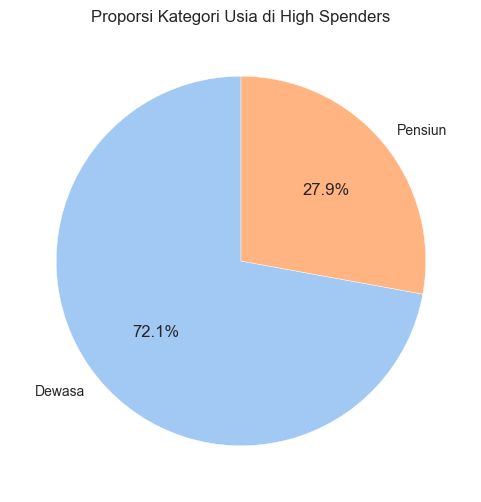

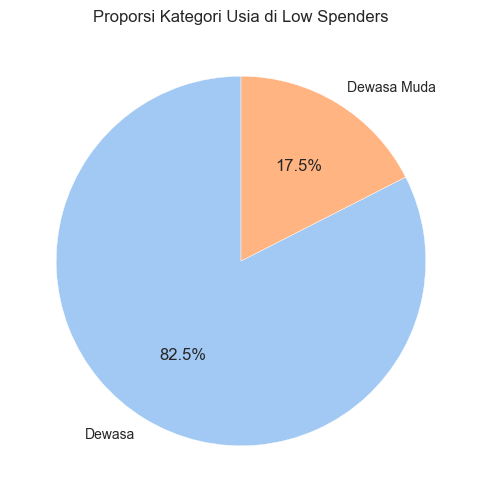

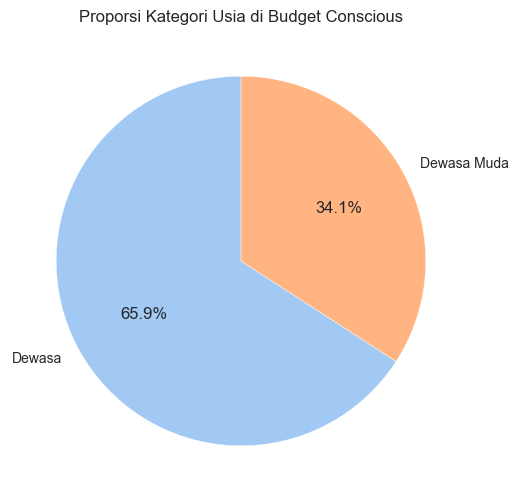

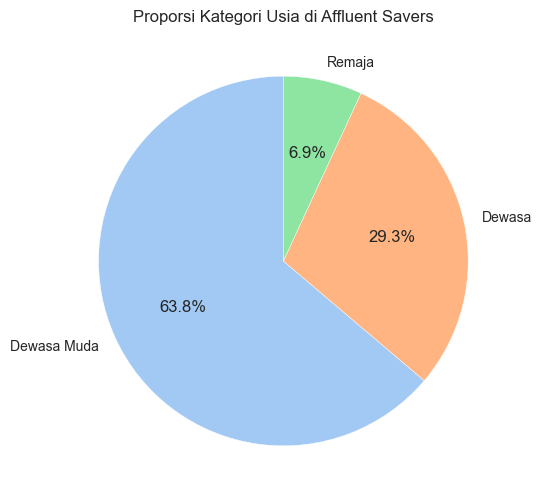

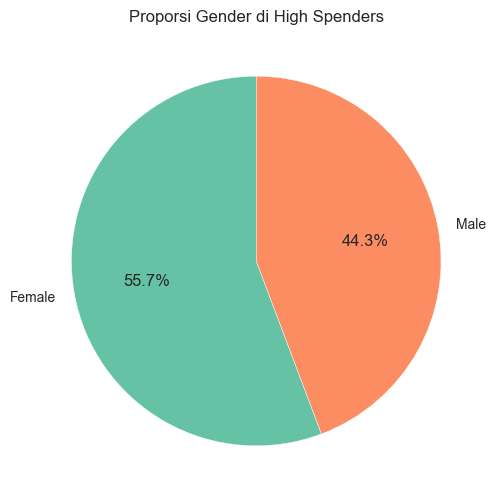

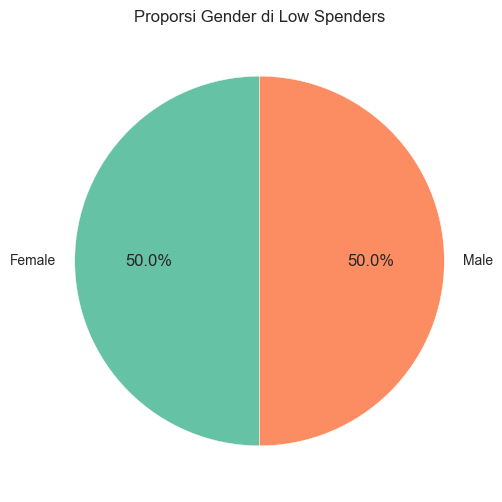

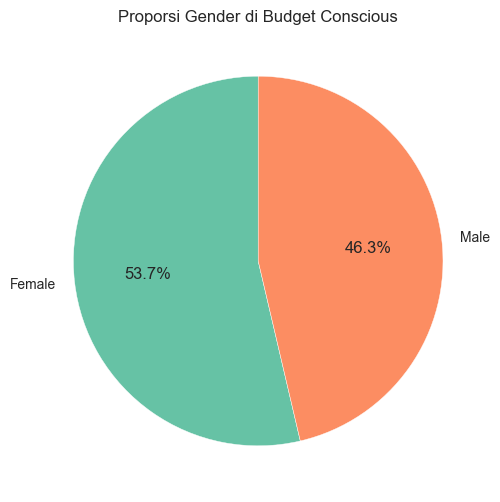

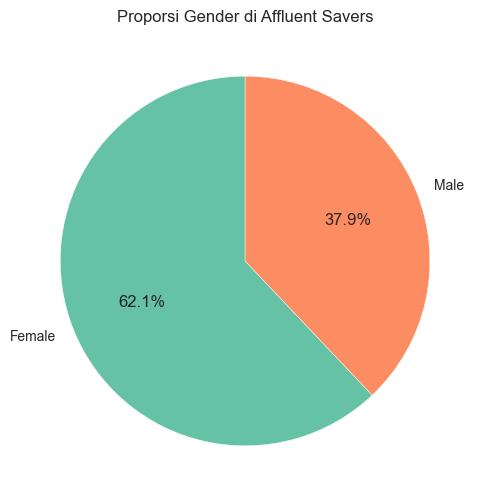

In [65]:
# Ide nama untuk setiap cluster
cluster_names = {
    0: 'High Spenders',
    1: 'Low Spenders',
    2: 'Budget Conscious',
    3: 'Affluent Savers',
}

# Atur gaya plot
sns.set_palette("pastel")
sns.set_style("whitegrid")

# Buat pie chart untuk kategori usia dalam setiap cluster
for cluster in sorted(df['C-means'].unique()):
    cluster_data = df[df['C-means'] == cluster]
    
    # Distribusi kategori usia
    age_category_distribution = cluster_data['kategori_usia'].value_counts()
    plt.figure(figsize=(6, 6))
    age_category_distribution.plot.pie(
        autopct='%1.1f%%',
        startangle=90,
        colors=sns.color_palette('pastel'),
        title=f'Proporsi Kategori Usia di {cluster_names.get(cluster, f"Cluster {cluster}")}'
    )
    plt.ylabel('')  # Hilangkan label sumbu Y
    plt.show()

# Buat pie chart untuk gender dalam setiap cluster
for cluster in sorted(df['C-means'].unique()):
    cluster_data = df[df['C-means'] == cluster]
    
    # Distribusi gender
    gender_distribution = cluster_data['Gender'].value_counts()
    plt.figure(figsize=(6, 6))
    gender_distribution.plot.pie(
        autopct='%1.1f%%',
        startangle=90,
        colors=sns.color_palette('Set2'),
        title=f'Proporsi Gender di {cluster_names.get(cluster, f"Cluster {cluster}")}'
    )                      
    plt.ylabel('')  # Hilangkan label sumbu Y
    plt.show()


### **3.5.2 Grafik Pendapatan Tahunan vs Skor Pengeluaran untuk analisis soft cluster** 
---
berikut ini kita akan membuat analisis untuk mengetahui pengaruh dari pendapatan tahunan terhadap pengeluaran dari berbagai golongan cluster 

#### **1.Grafik pendapatan tahunan vs skor pengeluaran untuk analisis soft cluster**

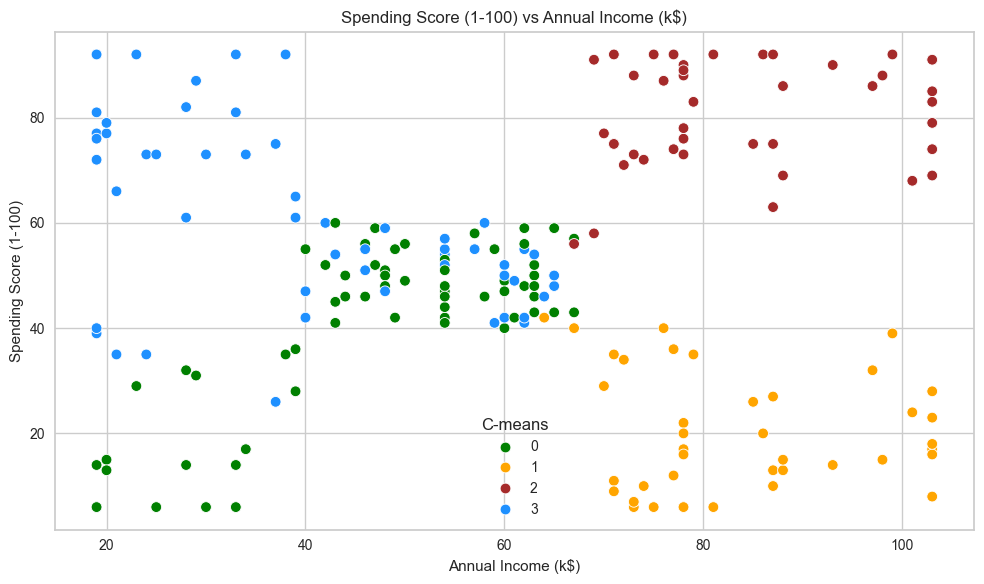

In [66]:
plt.figure(figsize=(10,6))
sns.scatterplot(x = 'Pendapatan_Tahunan',y = 'Skor_Pengeluaran',hue="C-means",
                palette=['green','orange','brown','dodgerblue', 'yellow'], legend='full',data = df, s = 60)
plt.xlabel('Annual Income (k$)')
plt.ylabel('Spending Score (1-100)')
plt.title('Spending Score (1-100) vs Annual Income (k$)')
plt.tight_layout()
plt.show()

In [67]:
CustomerGroup1 = df.groupby("C-means")[["Age","Pendapatan_Tahunan","Skor_Pengeluaran"]].mean()
print(CustomerGroup1.head())

print('''
Berdasarkan hasil output berikut dapat diketahui segmentasi pelanggan berdasarkan klaster c-means 
1. pada klaster 0 kita tahu untuk usia 54 tahun dengan pendapatan tahunan 47 k dan skor pengeluaran sebesar 41 
2. Pada klaster 1 kita tahu untuk usia 40 tahun dengan pendapatan tahunan 83 k dan skor pengeluaran sebesar 20 
3. Pada klaster 2 kita tahu untuk usia 32 tahun dengan pendapatan tahunan 83 k dan skor pengeluaran sebesar 80
4. Pada klaster 3 kita tahu untuk usia 25 tahun debgan pendapatan tahunan 39 k dan skor pengeluaran sebesar 58  
''')

               Age  Pendapatan_Tahunan  Skor_Pengeluaran
C-means                                                 
0        54.475410           47.475410         41.442623
1        40.275000           83.825000         20.075000
2        32.731707           83.585366         80.463415
3        25.758621           39.448276         58.586207

Berdasarkan hasil output berikut dapat diketahui segmentasi pelanggan berdasarkan klaster c-means 
1. pada klaster 0 kita tahu untuk usia 54 tahun dengan pendapatan tahunan 47 k dan skor pengeluaran sebesar 41 
2. Pada klaster 1 kita tahu untuk usia 40 tahun dengan pendapatan tahunan 83 k dan skor pengeluaran sebesar 20 
3. Pada klaster 2 kita tahu untuk usia 32 tahun dengan pendapatan tahunan 83 k dan skor pengeluaran sebesar 80
4. Pada klaster 3 kita tahu untuk usia 25 tahun debgan pendapatan tahunan 39 k dan skor pengeluaran sebesar 58  



#### **2.visualisasi boxplot untuk fuzzy c-means**

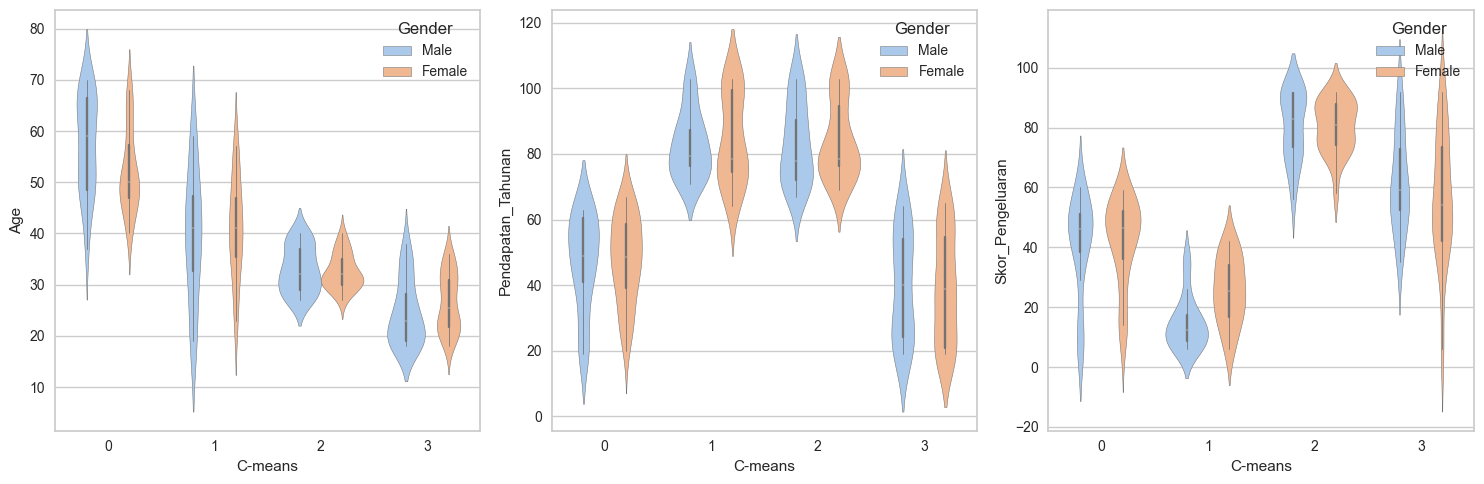

In [68]:
fig, ax = plt.subplots(1,3, figsize=(15,5))

sns.violinplot(x ='C-means', y ='Age', data = df, hue='Gender', ax=ax[0])
sns.violinplot(x ='C-means', y ='Pendapatan_Tahunan',  hue='Gender', data = df, ax=ax[1])
sns.violinplot(x ='C-means', y ='Skor_Pengeluaran', hue='Gender', data = df, ax=ax[2])
plt.tight_layout()
plt.show()

#### 3.visualisasi data untuk segmentasi pelanggan cluster 0

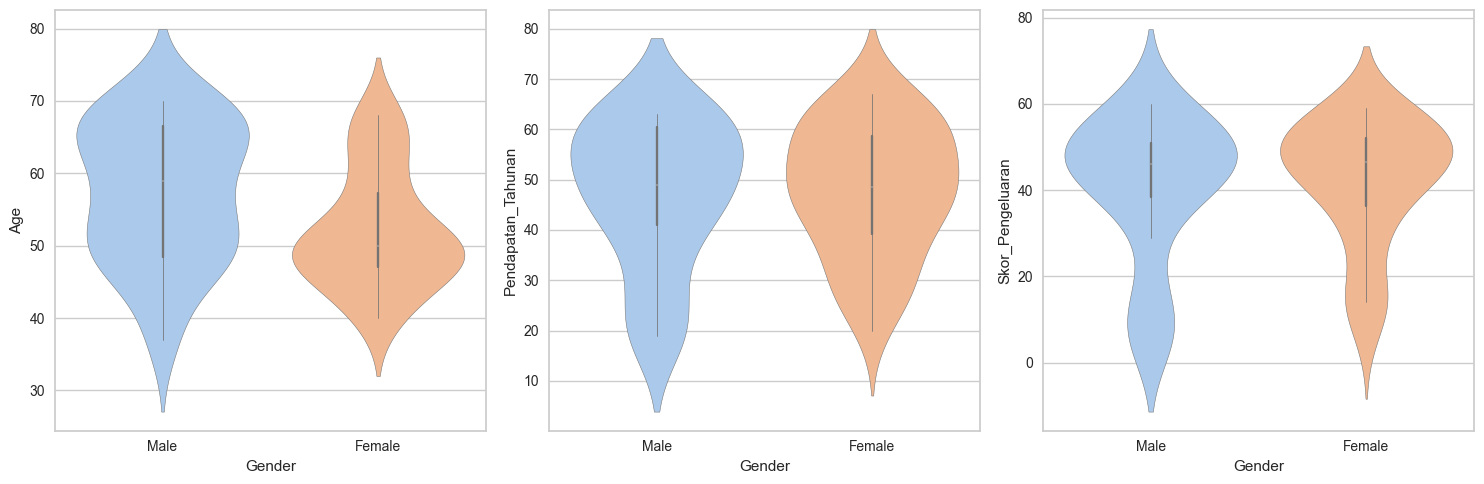

In [69]:
group_1 = df[df['C-means']==0]

fig, ax = plt.subplots(1, 3, figsize=(15,5))
sns.violinplot(x = 'Gender', y = 'Age', data = group_1, hue='Gender', ax=ax[0])
sns.violinplot(x = 'Gender', y = 'Pendapatan_Tahunan',  hue='Gender', data = group_1, ax=ax[1])
sns.violinplot(x = 'Gender', y = 'Skor_Pengeluaran',  hue='Gender', data = group_1, ax=ax[2])
plt.tight_layout()
plt.show()

#### 4.visualisasi data untuk segmentasi pelanggan cluter 1

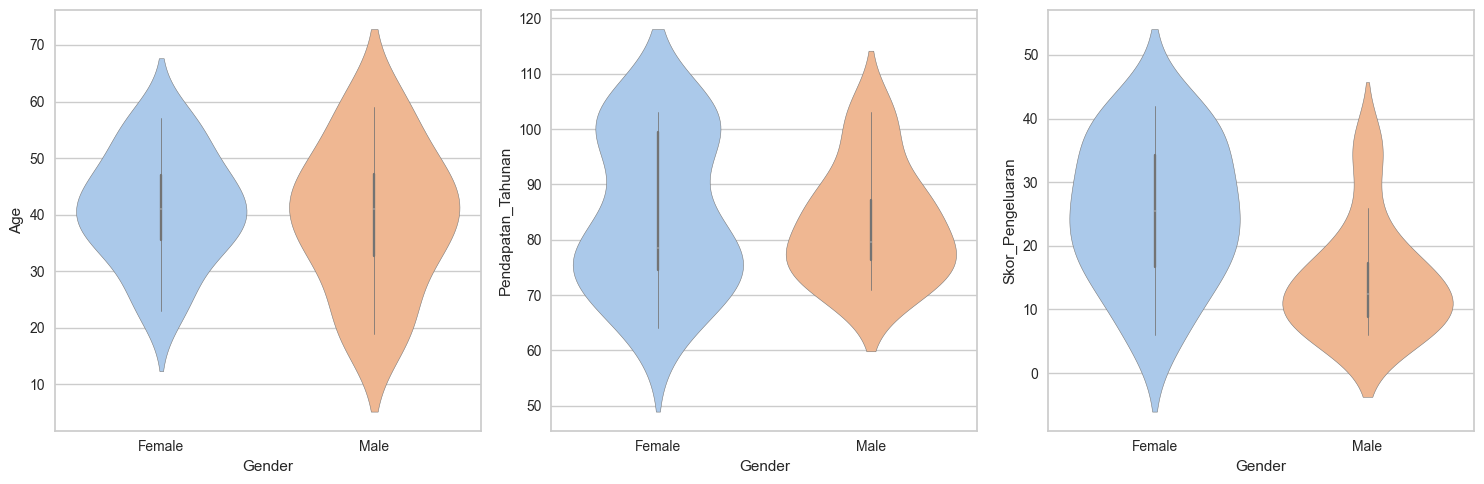

In [70]:
group_2 = df[df['C-means']==1]

fig, ax = plt.subplots(1, 3, figsize=(15,5))
sns.violinplot(x = 'Gender', y = 'Age', data = group_2, hue='Gender', ax=ax[0])
sns.violinplot(x = 'Gender', y = 'Pendapatan_Tahunan',  hue='Gender', data = group_2, ax=ax[1])
sns.violinplot(x = 'Gender', y = 'Skor_Pengeluaran',  hue='Gender', data = group_2, ax=ax[2])
plt.tight_layout()
plt.show()

#### 5.visualisasi data untuk segmentatsi pelanggan di cluster 2

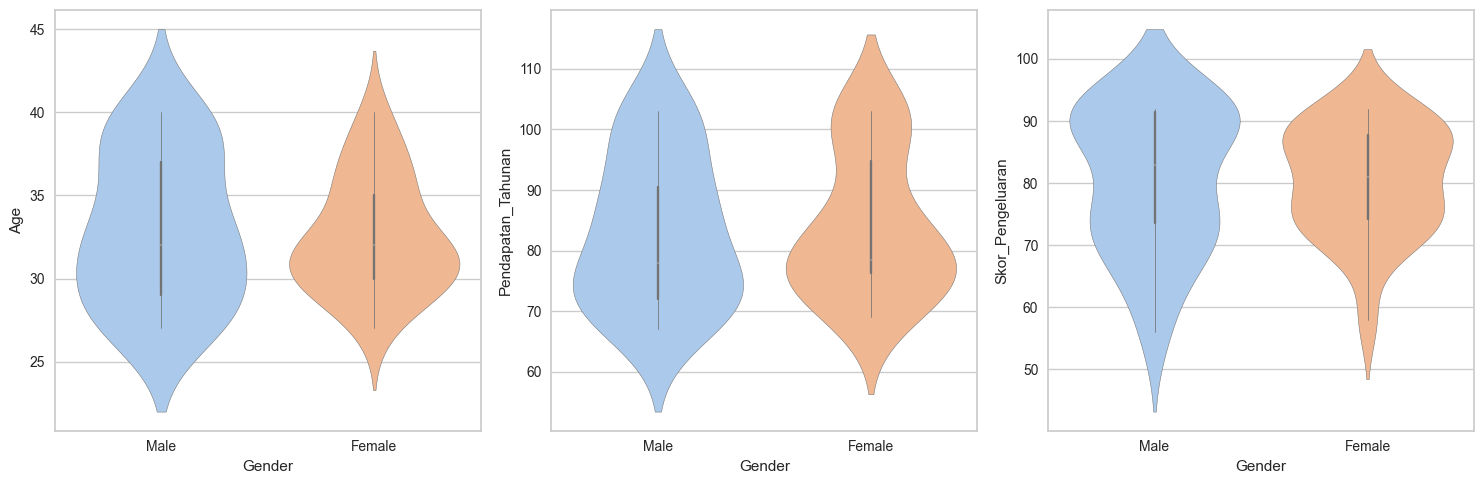

In [71]:
group_3 = df[df['C-means']==2]

fig, ax = plt.subplots(1, 3, figsize=(15,5))
sns.violinplot(x = 'Gender', y = 'Age', data = group_3, hue='Gender', ax=ax[0])
sns.violinplot(x = 'Gender', y = 'Pendapatan_Tahunan',  hue='Gender', data = group_3, ax=ax[1])
sns.violinplot(x = 'Gender', y = 'Skor_Pengeluaran',  hue='Gender', data = group_3, ax=ax[2])
plt.tight_layout()
plt.show()

#### 6 visualisasi data untuk segmentasi pelanggan di cluster 3

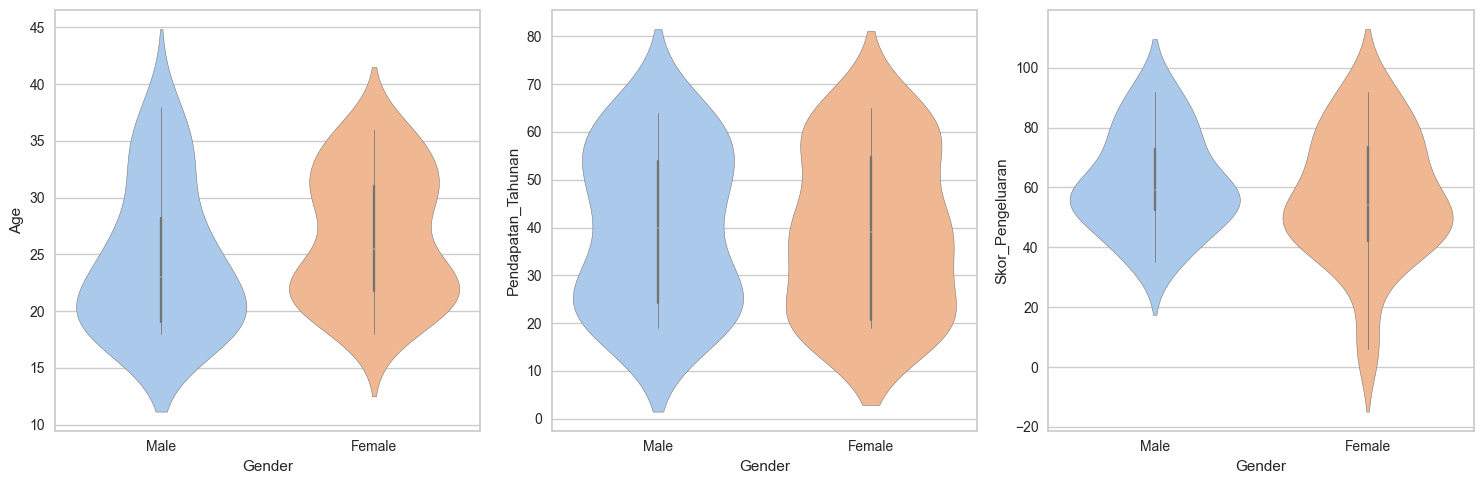

In [72]:
group_4 = df[df['C-means']==3]

fig, ax = plt.subplots(1, 3, figsize=(15,5))
sns.violinplot(x = 'Gender', y = 'Age', hue='Gender', data = group_4, ax=ax[0])
sns.violinplot(x = 'Gender', y = 'Pendapatan_Tahunan', hue='Gender', data = group_4, ax=ax[1])
sns.violinplot(x = 'Gender', y = 'Skor_Pengeluaran', hue='Gender', data = group_4, ax=ax[2])
plt.tight_layout()
plt.show()

In [141]:
from sklearn.mixture import GaussianMixture

# Load datasheet
df_customer = pd.read_csv('../data/Mall_Customers.csv')

# Winsorizing kolom pendapatan tahunan dan skor pengeluaran
df_customer['Annual Income (k$)'] = winsorize(df_customer['Annual Income (k$)'], limits=[0.05, 0.05])
df_customer['Spending Score (1-100)'] = winsorize(df_customer['Spending Score (1-100)'], limits=[0.05, 0.05])

# Menghapus kolom 'CustomerID'
df_customer.drop(['CustomerID'], axis=1, inplace=True)

# Preprocessing kolom kategorik menjadi numerik menggunakan LabelEncoder
label_encoder = LabelEncoder()
df_customer['Gender'] = label_encoder.fit_transform(df_customer['Gender'])

# Pisahkan kolom gender dan hapus kolom gender dari DataFrame
Gender = df_customer['Gender']
df_customer.drop('Gender', axis=1, inplace=True)

# Preprocessing kolom numerik dengan z-score
scaler = StandardScaler()
scaled_data = scaler.fit_transform(df_customer[['Age', 'Annual Income (k$)', 'Spending Score (1-100)']])

# Buat DataFrame baru dari hasil transformasi
df_customer_scaled = pd.DataFrame(scaled_data, columns=['Age', 'Annual Income (k$)', 'Spending Score (1-100)'])

# Gabungkan kolom Gender yang telah disimpan sebelumnya
df_customer_scaled['Gender'] = Gender

# Print hasil DataFrame
print(df_customer_scaled.head())

        Age  Annual Income (k$)  Spending Score (1-100)  Gender
0 -1.424569           -1.687429               -0.440591       1
1 -1.281035           -1.687429                1.220525       1
2 -1.352802           -1.687429               -1.745755       0
3 -1.137502           -1.687429                1.062324       0
4 -0.563369           -1.687429               -0.401041       0


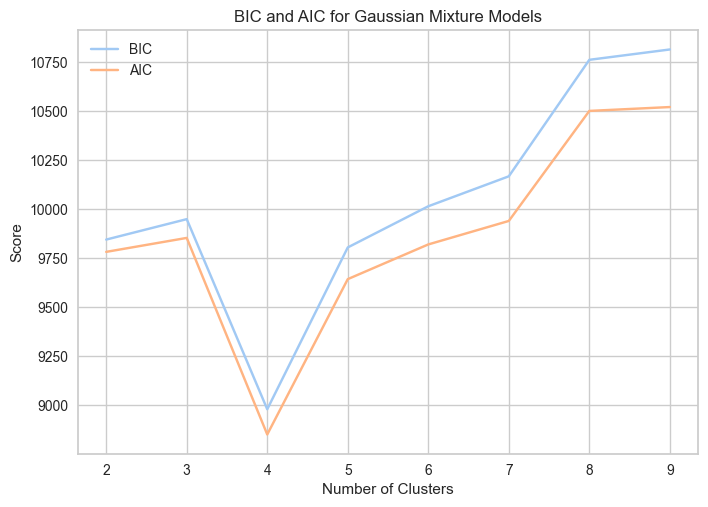

In [143]:
bic_scores = []
aic_scores = []
for n in range(2, 10):
    gmm = GaussianMixture(n_components=n, random_state=42)
    gmm.fit(df_customer)
    bic_scores.append(gmm.bic(scaled_data))
    aic_scores.append(gmm.aic(scaled_data))

plt.plot(range(2, 10), bic_scores, label='BIC')
plt.plot(range(2, 10), aic_scores, label='AIC')
plt.xlabel('Number of Clusters')
plt.ylabel('Score')
plt.legend()
plt.title('BIC and AIC for Gaussian Mixture Models')
plt.show()


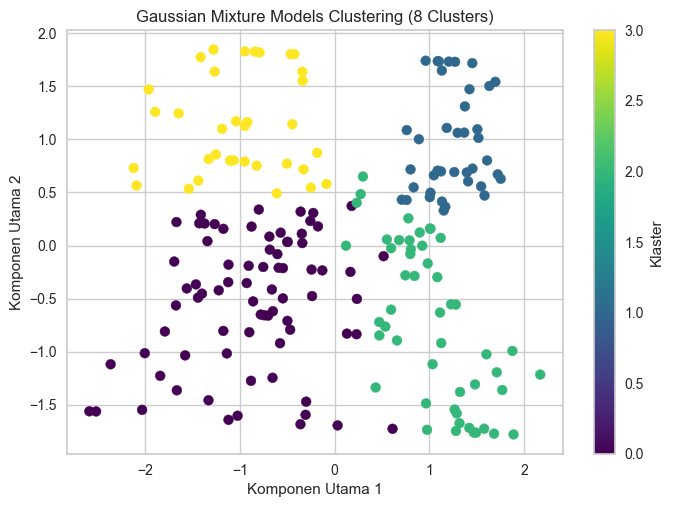

In [146]:
gmm =  GaussianMixture(n_components=4, random_state=42)
gmm.fit(df_customer_scaled)
gmm_labels = gmm.predict(df_customer_scaled)

# Visualisasi dengan PCA
pca = PCA(n_components=2)
data_pca = pca.fit_transform(scaled_data)

plt.scatter(data_pca[:, 0], data_pca[:, 1], c=gmm_labels, cmap='viridis', s=50)
plt.title('Gaussian Mixture Models Clustering (8 Clusters)')
plt.xlabel('Komponen Utama 1')
plt.ylabel('Komponen Utama 2')
plt.colorbar(label='Klaster')
plt.show()

In [151]:
sil_score = silhouette_score(scaled_data, gmm_labels)
db_index = davies_bouldin_score(scaled_data, gmm_labels)

df['GMM'] = gmm_labels

print(f"Silhouette Score: {sil_score:.3f}")
print(f"Davies-Bouldin Index: {db_index:.3f}")

print('''
Dari hasil pengukuran tersbeut dapat diketahi bahwa dengan menggunakan model gmm 
1.kita mendapatkan silhoutte score sebesar 0.390 ini merupakan paling tertinggi dari ketiga model yang kita coba 
2.dan untuk davies bounding index yang kita miliki sebesar 0.971 ini menunjukan bahwa data kita lebih kompak dibanding dengan 2 model sebelmnya
''')

Silhouette Score: 0.390
Davies-Bouldin Index: 0.971

Dari hasil pengukuran tersbeut dapat diketahi bahwa dengan menggunakan model gmm 
1.kita mendapatkan silhoutte score sebesar 0.390 ini merupakan paling tertinggi dari ketiga model yang kita coba 
2.dan untuk davies bounding index yang kita miliki sebesar 0.971 ini menunjukan bahwa data kita lebih kompak dibanding dengan 2 model sebelmnya



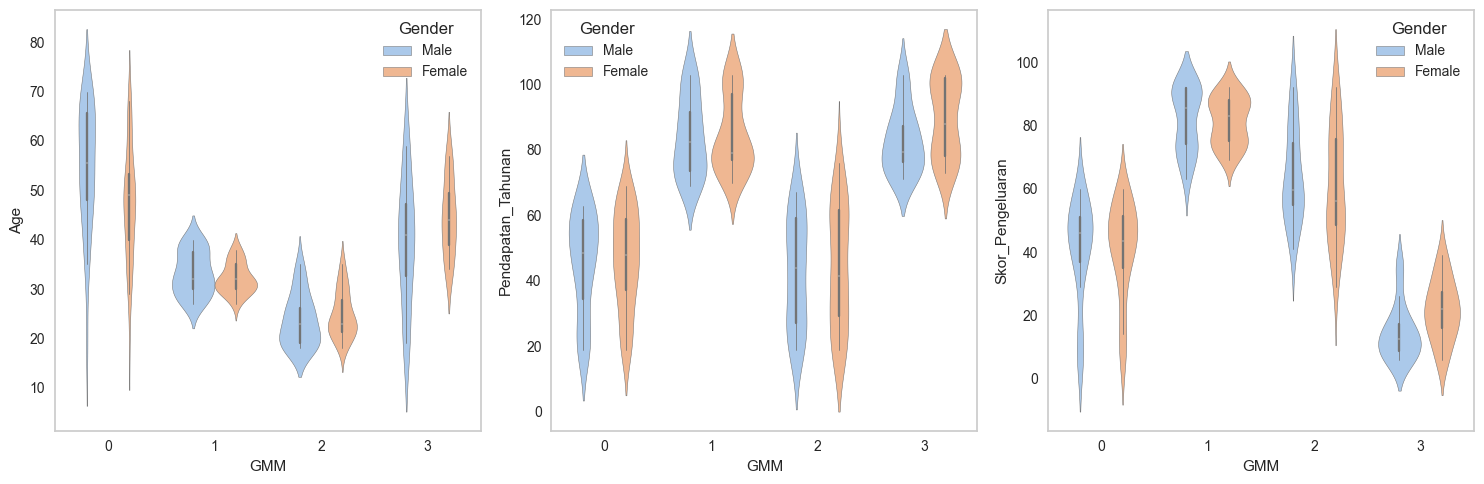

In [152]:
fig, ax = plt.subplots(1,3, figsize=(15,5))

sns.violinplot(x ='GMM', y ='Age', data = df, hue='Gender', ax=ax[0])
sns.violinplot(x ='GMM', y ='Pendapatan_Tahunan', data = df, hue='Gender', ax=ax[1])
sns.violinplot(x ='GMM', y ='Skor_Pengeluaran', data = df, hue='Gender', ax=ax[2])

for axis in ax:
    axis.grid(False)
    
plt.tight_layout()
plt.show()

In [156]:
CustomerGroup2 = df.groupby("GMM")[["Age","Pendapatan_Tahunan","Skor_Pengeluaran"]].mean()
print(CustomerGroup2.head())

print('''
Berdasarkan hasil output berikut dapat diketahui segmentasi pelanggan berdasarkan klaster c-means 
1. pada klaster 0 kita tahu untuk usia 50 tahun dengan pendapatan tahunan 45 k dan skor pengeluaran sebesar 40 
2. Pada klaster 1 kita tahu untuk usia 32 tahun dengan pendapatan tahunan 84 k dan skor pengeluaran sebesar 81 
3. Pada klaster 2 kita tahu untuk usia 24 tahun dengan pendapatan tahunan 43 k dan skor pengeluaran sebesar 62
4. Pada klaster 3 kita tahu untuk usia 41 tahun debgan pendapatan tahunan 85 k dan skor pengeluaran sebesar 17  
''')

           Age  Pendapatan_Tahunan  Skor_Pengeluaran
GMM                                                 
0    50.184211           45.973684         40.802632
1    32.692308           84.384615         81.666667
2    24.440000           43.500000         62.480000
3    41.685714           85.828571         17.657143

Berdasarkan hasil output berikut dapat diketahui segmentasi pelanggan berdasarkan klaster c-means 
1. pada klaster 0 kita tahu untuk usia 50 tahun dengan pendapatan tahunan 45 k dan skor pengeluaran sebesar 40 
2. Pada klaster 1 kita tahu untuk usia 32 tahun dengan pendapatan tahunan 84 k dan skor pengeluaran sebesar 81 
3. Pada klaster 2 kita tahu untuk usia 24 tahun dengan pendapatan tahunan 43 k dan skor pengeluaran sebesar 62
4. Pada klaster 3 kita tahu untuk usia 41 tahun debgan pendapatan tahunan 85 k dan skor pengeluaran sebesar 17  



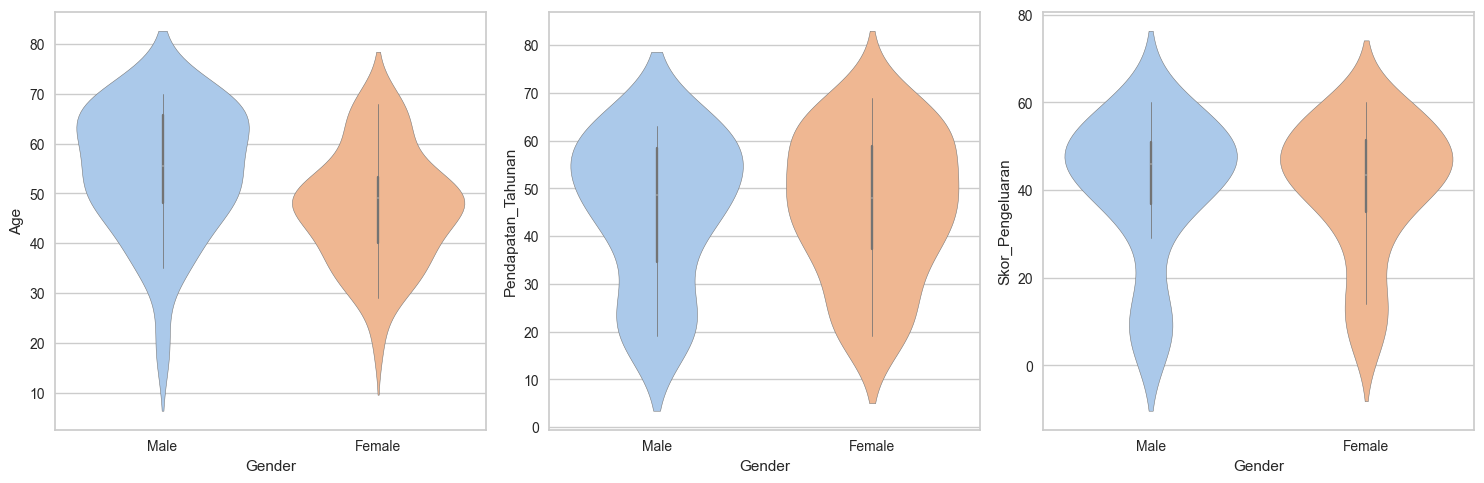

In [157]:
group_1 = df[df['GMM']==0]

fig, ax = plt.subplots(1, 3, figsize=(15,5))
sns.violinplot(x = 'Gender', y = 'Age', data = group_1, hue='Gender', ax=ax[0])
sns.violinplot(x = 'Gender', y = 'Pendapatan_Tahunan',  hue='Gender', data = group_1, ax=ax[1])
sns.violinplot(x = 'Gender', y = 'Skor_Pengeluaran',  hue='Gender', data = group_1, ax=ax[2])
plt.tight_layout()
plt.show()

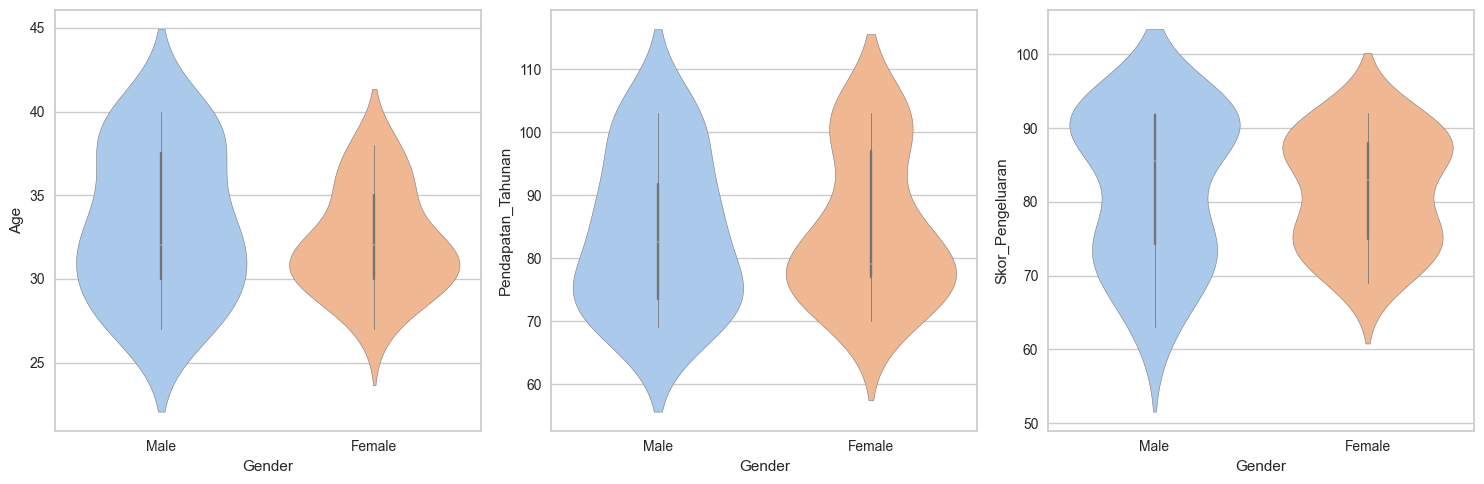

In [158]:
group_2 = df[df['GMM']==1]

fig, ax = plt.subplots(1, 3, figsize=(15,5))
sns.violinplot(x = 'Gender', y = 'Age', data = group_2, hue='Gender', ax=ax[0])
sns.violinplot(x = 'Gender', y = 'Pendapatan_Tahunan',  hue='Gender', data = group_2, ax=ax[1])
sns.violinplot(x = 'Gender', y = 'Skor_Pengeluaran',  hue='Gender', data = group_2, ax=ax[2])
plt.tight_layout()
plt.show()

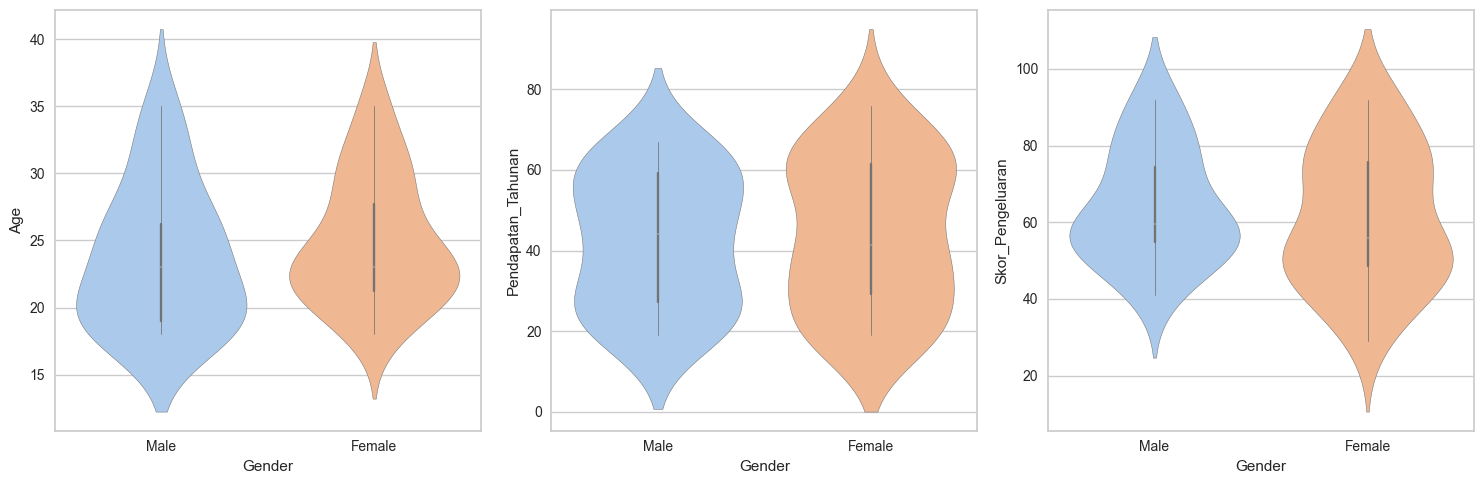

In [160]:
group_3 = df[df['GMM']==2]

fig, ax = plt.subplots(1, 3, figsize=(15,5))
sns.violinplot(x = 'Gender', y = 'Age', data = group_3, hue='Gender', ax=ax[0])
sns.violinplot(x = 'Gender', y = 'Pendapatan_Tahunan',  hue='Gender', data = group_3, ax=ax[1])
sns.violinplot(x = 'Gender', y = 'Skor_Pengeluaran',  hue='Gender', data = group_3, ax=ax[2])
plt.tight_layout()
plt.show()

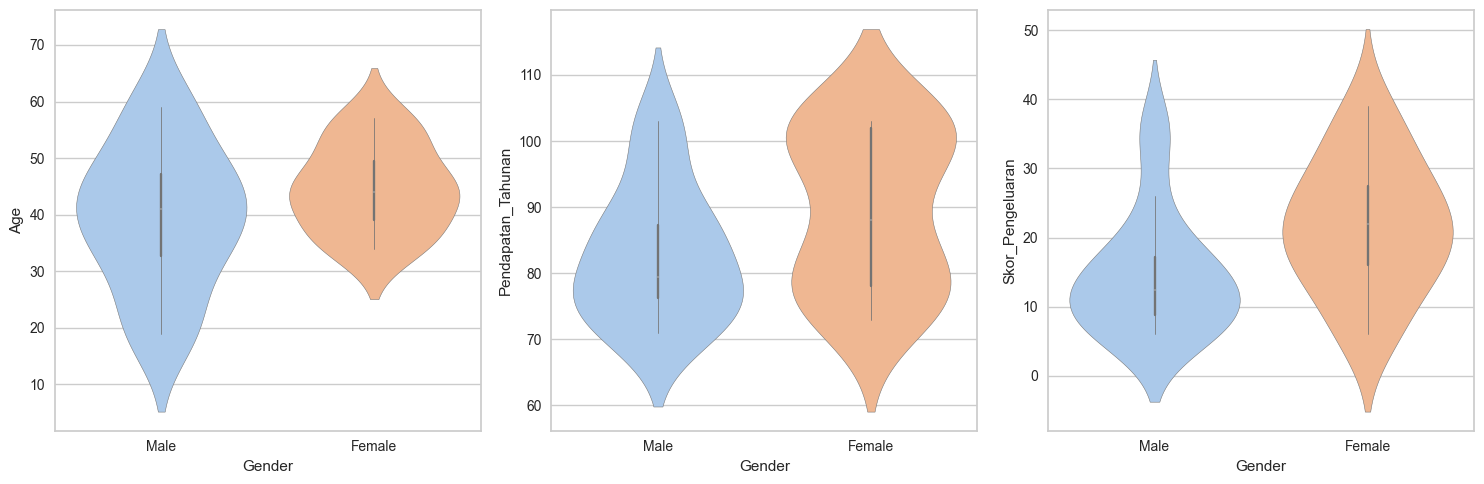

In [161]:
group_4 = df[df['GMM']==3]

fig, ax = plt.subplots(1, 3, figsize=(15,5))
sns.violinplot(x = 'Gender', y = 'Age', data = group_4, hue='Gender', ax=ax[0])
sns.violinplot(x = 'Gender', y = 'Pendapatan_Tahunan',  hue='Gender', data = group_4, ax=ax[1])
sns.violinplot(x = 'Gender', y = 'Skor_Pengeluaran',  hue='Gender', data = group_4, ax=ax[2])
plt.tight_layout()
plt.show()